In [277]:
import pandas as pd # type:ignore
import numpy as np # type:ignore
import matplotlib.pyplot as plt # type:ignore
import seaborn as sns # type:ignore
from sklearn.datasets import make_blobs # type:ignore
from scipy.stats import multivariate_normal # type:ignore
from sklearn.metrics import confusion_matrix,classification_report # type:ignore
import warnings # type:ignore
from scipy.optimize import linear_sum_assignment # type:ignore
from matplotlib.lines import Line2D # type:ignore
from sklearn.preprocessing import StandardScaler # type:ignore
from sklearn.decomposition import PCA # type:ignore
from sklearn.manifold import TSNE # type:ignore
import umap # type:ignore
from sklearn.cluster import KMeans,DBSCAN # type:ignore
from sklearn.mixture import GaussianMixture # type:ignore
from sklearn.neighbors import NearestNeighbors # type:ignore
warnings.filterwarnings("ignore", category=UserWarning)

# data

In [278]:
np.random.seed(42)

In [279]:
def generate_correlated_clusters(n_samples,n_features,n_clusters,correlation=0.5,random_state=None):

    np.random.seed(random_state)

    X_blobs,y_blobs = make_blobs(n_samples=n_samples,centers=n_clusters,n_features=n_features,random_state=random_state)

    centers = np.array([X_blobs[y_blobs == i].mean(axis=0) for i in range(n_clusters)])

    X,y = [],[]

    for i,center in enumerate(centers):
    
        cov_matrix = np.full((n_features,n_features),correlation)  
        np.fill_diagonal(cov_matrix,1)  

        cluster_samples = np.random.multivariate_normal(mean=center,cov=cov_matrix,size=n_samples // n_clusters)

        X.append(cluster_samples)
        y.append(np.full(n_samples // n_clusters, i)) 

    X = np.vstack(X)
    y = np.hstack(y)

    return X, y

In [280]:
X, y = generate_correlated_clusters(n_samples=500,n_features=5,n_clusters=3,correlation=0.2,random_state=42)
X = X + np.random.normal(scale=3,size=X.shape) 

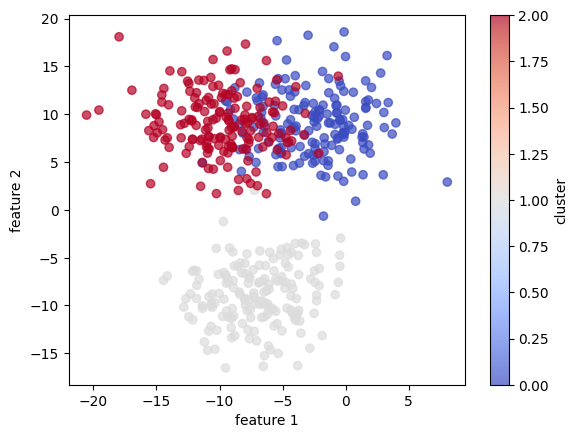

In [281]:
plt.scatter(X[:,0],X[:,1],c=y,cmap='coolwarm',alpha=0.7)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.colorbar(label="cluster")
plt.show()

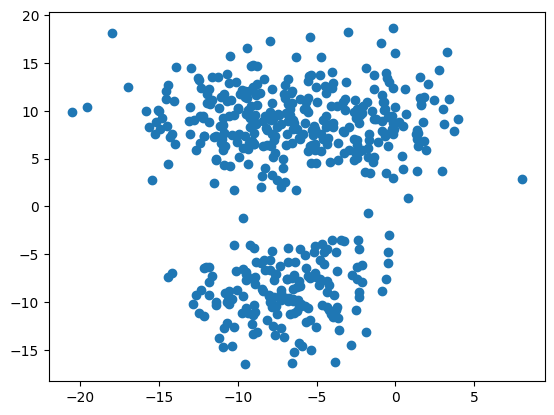

In [282]:
plt.scatter(X[:,0],X[:,1])
plt.show()

In [283]:
corr_dataset = pd.DataFrame(X) 

In [284]:
corr_dataset.columns = [f"vab_{col+1}" for col in corr_dataset.columns]

In [285]:
corr_dataset['target'] = y

In [286]:
corr_dataset

vab_1      vab_2     vab_3      vab_4      vab_5  target
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0
..         ...        ...       ...        ...        ...     ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2

[498 rows x 6 columns]

In [287]:
# sns.pairplot(corr_dataset)

## correlation matrix

In [288]:
corr_dataset.iloc[:,:-1].corr()

vab_1     vab_2     vab_3     vab_4     vab_5
vab_1  1.000000  0.074492 -0.179078  0.434506 -0.044214
vab_2  0.074492  1.000000 -0.263537 -0.318261 -0.797338
vab_3 -0.179078 -0.263537  1.000000 -0.100187  0.234164
vab_4  0.434506 -0.318261 -0.100187  1.000000  0.304148
vab_5 -0.044214 -0.797338  0.234164  0.304148  1.000000

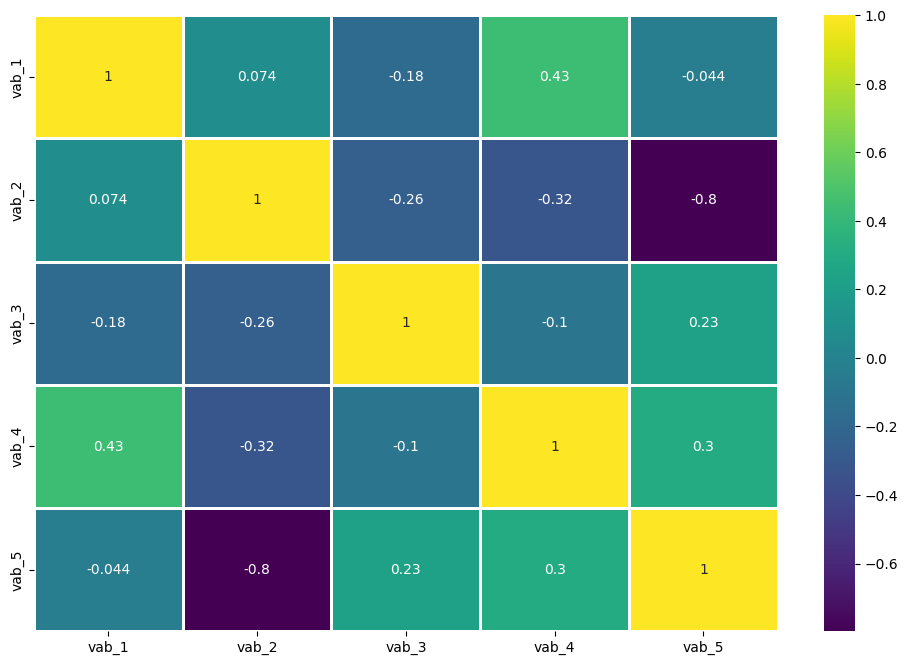

In [289]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_dataset.iloc[:,:-1].corr(),cmap='viridis',annot=True,linewidths=1)
plt.show()

## data standardization

In [290]:
X_values = corr_dataset.iloc[:,:-1].values

In [291]:
y_values = corr_dataset.iloc[:,-1].values

In [292]:
scaler = StandardScaler()

In [293]:
X_values = scaler.fit_transform(X_values)

In [294]:
np.mean(X_values),np.std(X_values)

(2.511155050075856e-16, 1.0)

In [295]:
pd.DataFrame(X_values)

0         1         2         3         4
0    0.803487  0.311093 -0.690590  1.241895 -1.193383
1    1.778879  0.541446 -0.914621  1.040716 -0.387992
2    1.273156  0.953100 -0.710097  0.655575 -1.277392
3    0.235790  1.621337  0.807835  0.082577 -1.300264
4    0.993344  0.745638 -0.356557  0.452454 -0.918211
..        ...       ...       ...       ...       ...
493 -1.922507  0.552040  1.112003 -1.224809 -0.353760
494 -0.649895  0.319131 -0.451523 -0.973522 -1.205595
495 -1.016967  0.316770  0.605134 -1.152939  0.251637
496  0.720907  0.531223 -0.892676 -2.112917 -1.159760
497 -1.839830  0.992361  0.402097 -0.728904 -1.888425

[498 rows x 5 columns]

<Axes: ylabel='Density'>

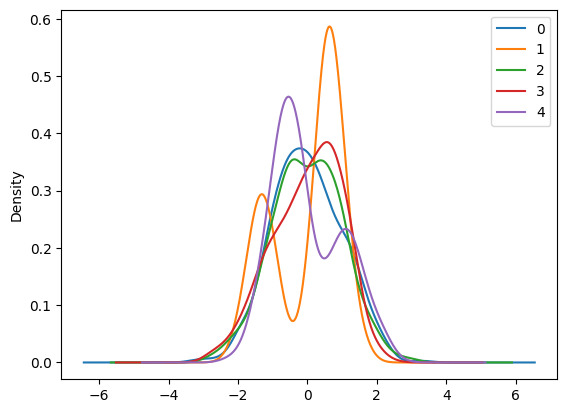

In [296]:
pd.DataFrame(X_values).plot(kind='density')

## pca 

In [297]:
pca_general = PCA()

In [298]:
pca_general.fit(X_values)

PCA()

In [299]:
explained_variance = pca_general.explained_variance_ratio_

In [300]:
explained_variance

array([0.41408457, 0.29979576, 0.15585339, 0.09023535, 0.04003092])

In [301]:
eigenvalues = pca_general.explained_variance_

In [302]:
pd.DataFrame(eigenvalues)

0
0  2.074589
1  1.501995
2  0.780835
3  0.452085
4  0.200557

In [303]:
eigenvectors = pca_general.components_

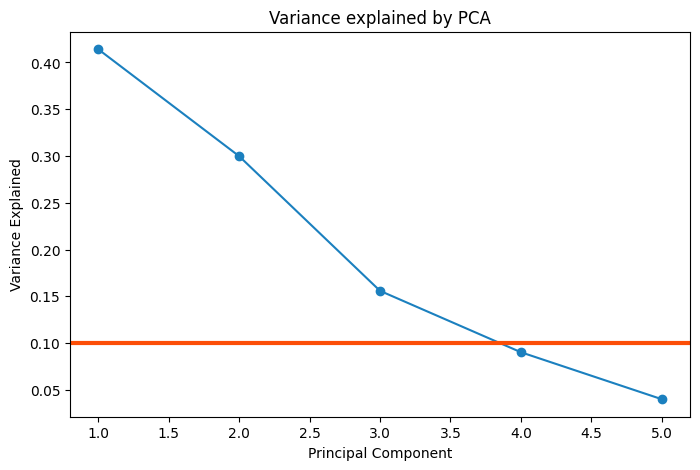

In [304]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='#1B80BF')
plt.axhline(y=0.1, color='#FC4E07', linewidth=3)
plt.title('Variance explained by PCA')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [305]:
pca = PCA(n_components=2)

In [306]:
principal_components = pca.fit_transform(X_values)

In [307]:
pd.DataFrame(principal_components).head(8)

0         1
0  0.658517  1.684841
1  0.395099  2.291326
2  1.320762  1.746992
3  1.610620  0.106453
4  0.952777  1.235345
5  1.463639  2.134621
6  1.100850  1.565868
7  0.673904  2.250496

In [308]:
principal_df = pd.DataFrame(data = principal_components,columns = ['principal component 1','principal component 2'])

In [309]:
final_df = pd.concat([principal_df,corr_dataset[['target']]],axis = 1)

In [310]:
final_df

principal component 1  principal component 2  target
0                 0.658517               1.684841       0
1                 0.395099               2.291326       0
2                 1.320762               1.746992       0
3                 1.610620               0.106453       0
4                 0.952777               1.235345       0
..                     ...                    ...     ...
493               0.790351              -2.417097       2
494               1.449652              -0.669389       2
495               0.333291              -1.605979       2
496               2.033003              -0.175498       2
497               2.041796              -1.598760       2

[498 rows x 3 columns]

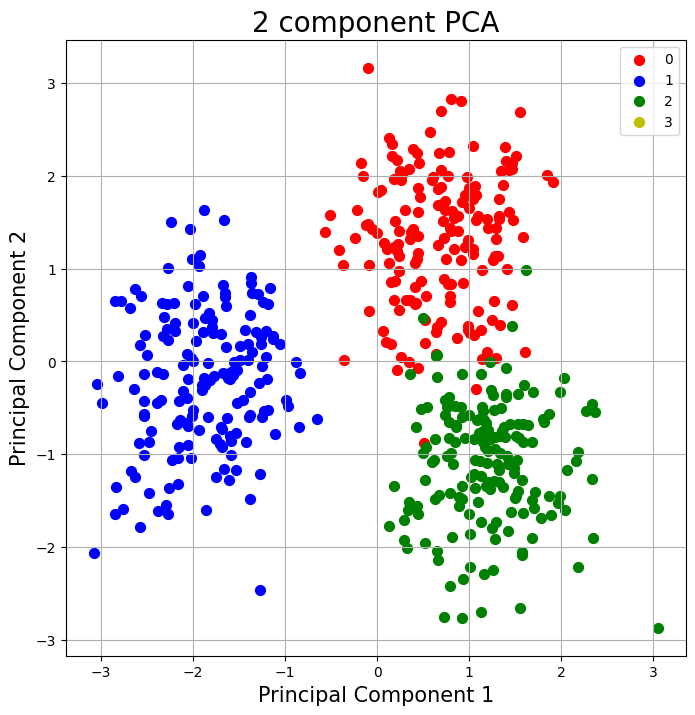

In [311]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1',fontsize = 15)
ax.set_ylabel('Principal Component 2',fontsize = 15)
ax.set_title('2 component PCA',fontsize = 20)

targets = [0,1,2,3]
colors = ['r','b','g','y']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['target'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               ,final_df.loc[indicesToKeep, 'principal component 2']
               ,c = color
               ,s = 50)
ax.legend(targets)
ax.grid()

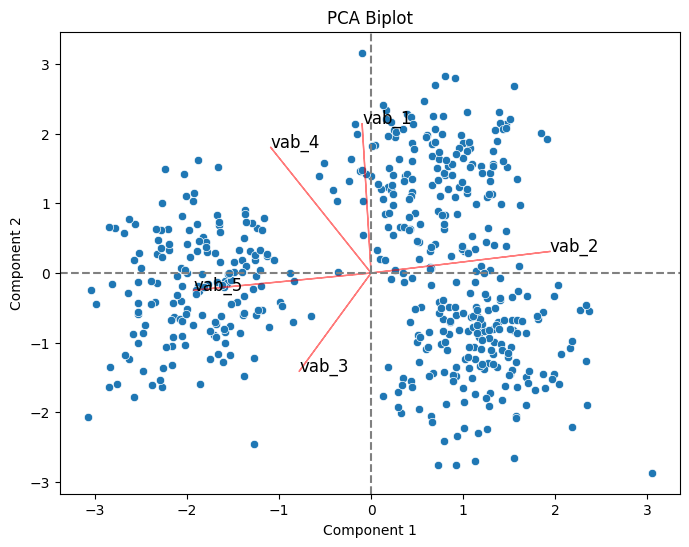

In [312]:
scores = pca.transform(X_values)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=scores[:, 0], y=scores[:, 1])
for i, col in enumerate(corr_dataset.iloc[:,:-1].columns):
    plt.arrow(0, 0, eigenvectors[0, i] * max(scores[:, 0]), eigenvectors[1, i] * max(scores[:, 1]), color='r', alpha=0.5)
    plt.text(eigenvectors[0, i] * max(scores[:, 0]), eigenvectors[1, i] * max(scores[:, 1]), col, fontsize=12)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Biplot')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.show()

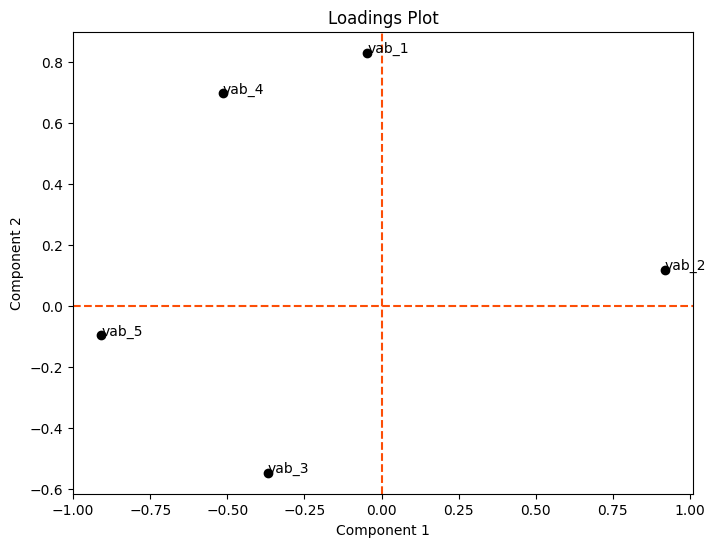

In [313]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 0], loadings[:, 1], color='black')
for i, txt in enumerate(corr_dataset.iloc[:,:-1].columns):
    plt.text(loadings[i, 0], loadings[i, 1], txt, fontsize=10)
plt.axhline(0, color='#FC4E07', linestyle='--')
plt.axvline(0, color='#FC4E07', linestyle='--')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Loadings Plot')
plt.show()

In [314]:
scores_pca = pca.transform(X_values)

In [315]:
pd.DataFrame(scores_pca).head()

0         1
0  0.658517  1.684841
1  0.395099  2.291326
2  1.320762  1.746992
3  1.610620  0.106453
4  0.952777  1.235345

## t-SNE

In [316]:
tsne = TSNE(n_components=2,random_state=42)

In [317]:
X_tsne = tsne.fit_transform(X_values)

In [318]:
tsne_data = pd.concat([pd.DataFrame(X_tsne,columns=('dim_1','dim_2')),corr_dataset['target']],axis=1)

In [319]:
tsne_data

dim_1      dim_2  target
0     9.372534  11.503856       0
1     4.550472  18.039286       0
2     6.800554  13.059919       0
3     9.709843   0.942504       0
4     6.693798  12.527792       0
..         ...        ...     ...
493  13.643978 -13.322453       2
494  22.653631  -5.450000       2
495  12.569039 -10.829222       2
496  25.547062  -2.302315       2
497  17.668365 -13.932341       2

[498 rows x 3 columns]

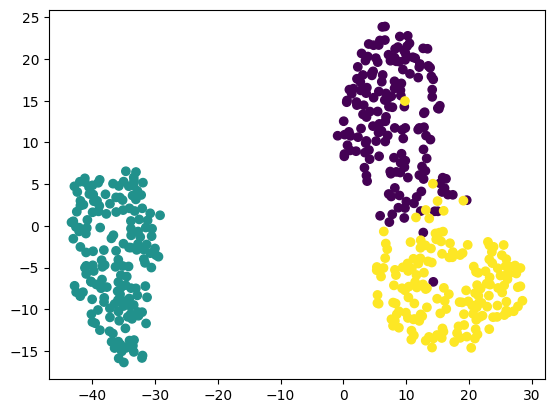

In [320]:
plt.scatter(x=tsne_data['dim_1'],y=tsne_data['dim_2'],c=tsne_data['target'])
plt.show()

In [321]:
tsne.kl_divergence_

0.613106369972229

## umap

In [322]:
umap = umap.UMAP(random_state=42)

In [323]:
X_umap = umap.fit_transform(X_values)

In [324]:
umap_data = pd.concat([pd.DataFrame(X_umap,columns=('dim_1','dim_2')),corr_dataset['target']],axis=1)

In [325]:
umap_data

dim_1     dim_2  target
0   -2.636525  0.589692       0
1   -3.703453 -0.416180       0
2   -3.269449  0.159279       0
3   -2.751825  2.449294       0
4   -3.260908  0.549845       0
..        ...       ...     ...
493 -2.197955  5.376609       2
494 -1.953868  7.038562       2
495 -2.552391  5.345685       2
496 -2.432659  7.855163       2
497 -1.433423  5.488331       2

[498 rows x 3 columns]

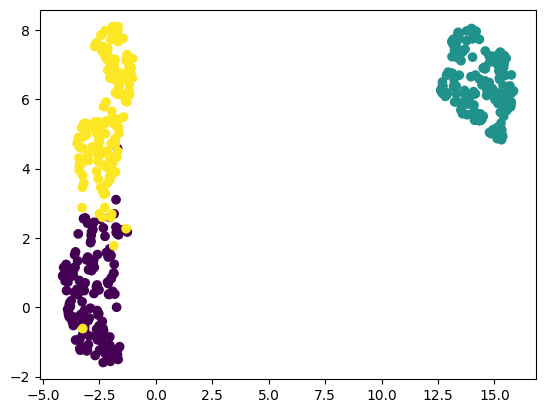

In [326]:
plt.scatter(umap_data['dim_1'],umap_data['dim_2'],c=umap_data['target'])
plt.show()

## k-means 

In [327]:
kmeans = KMeans(n_clusters=3,init='k-means++',random_state=42)

In [328]:
kmeans.fit(X_values)

KMeans(n_clusters=3, random_state=42)

In [329]:
df_kmeans = corr_dataset.copy()

In [330]:
df_kmeans['k_means'] = kmeans.labels_

In [331]:
df_kmeans

vab_1      vab_2     vab_3      vab_4      vab_5  target  k_means
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0        2
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0        2
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0        2
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0        2
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0        2
..         ...        ...       ...        ...        ...     ...      ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2        1
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2        1
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2        1
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2        1
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2        1

[498 rows x 7 columns]

In [332]:
y_true = df_kmeans['target'].values  
y_kmeans = df_kmeans['k_means'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_kmeans['k_means'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_kmeans['k_means'] == y_true))

accuracy before: 0.012048192771084338
accuracy after: 0.9779116465863453


In [333]:
df_kmeans

vab_1      vab_2     vab_3      vab_4      vab_5  target  k_means
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0        0
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0        0
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0        0
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0        0
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0        0
..         ...        ...       ...        ...        ...     ...      ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2        2
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2        2
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2        2
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2        2
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2        2

[498 rows x 7 columns]

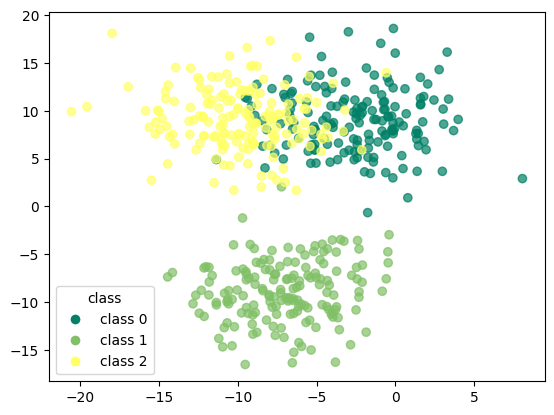

In [334]:
scatter = plt.scatter(df_kmeans.iloc[:, 0], df_kmeans.iloc[:, 1], 
                      c=df_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

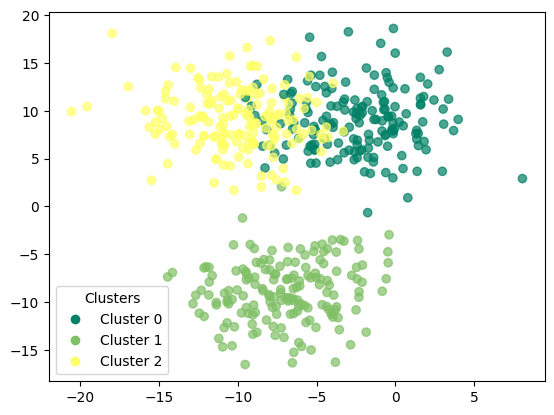

In [335]:
scatter = plt.scatter(df_kmeans.iloc[:, 0], df_kmeans.iloc[:, 1], 
                      c=df_kmeans['k_means'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_kmeans['k_means'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [336]:
kmeans.cluster_centers_

array([[-0.1194833 , -1.3212833 ,  0.3964788 ,  0.4853094 ,  1.20701647],
       [-0.81202772,  0.66777341,  0.13144075, -1.10068886, -0.63019514],
       [ 0.92107067,  0.6535953 , -0.52397128,  0.60510361, -0.57714093]])

In [337]:
print(confusion_matrix(df_kmeans['target'],df_kmeans['k_means']))

[[161   0   5]
 [  0 166   0]
 [  6   0 160]]


In [338]:
print(classification_report(df_kmeans['target'],df_kmeans['k_means']))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       166
           1       1.00      1.00      1.00       166
           2       0.97      0.96      0.97       166

    accuracy                           0.98       498
   macro avg       0.98      0.98      0.98       498
weighted avg       0.98      0.98      0.98       498



### k-means with pca

In [339]:
kmeans_pca = KMeans(n_clusters=3,init='k-means++',random_state=42)

In [340]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=3, random_state=42)

In [341]:
df_pca_kmeans = corr_dataset.copy()

In [342]:
df_pca_kmeans["kmeans_pca"] = kmeans_pca.labels_

In [343]:
df_pca_kmeans

vab_1      vab_2     vab_3      vab_4      vab_5  target  kmeans_pca
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0           2
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0           2
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0           2
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0           1
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0           2
..         ...        ...       ...        ...        ...     ...         ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2           1
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2           1
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2           1
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2           1
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2           1

[498 rows x 7 columns]

In [344]:
y_true = df_pca_kmeans['target'].values  
y_kmeans = df_pca_kmeans['kmeans_pca'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_pca_kmeans['kmeans_pca'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_pca_kmeans['kmeans_pca'] == y_true))

accuracy before: 0.008032128514056224
accuracy after: 0.9718875502008032


In [345]:
df_pca_kmeans

vab_1      vab_2     vab_3      vab_4      vab_5  target  kmeans_pca
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0           0
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0           0
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0           0
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0           2
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0           0
..         ...        ...       ...        ...        ...     ...         ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2           2
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2           2
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2           2
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2           2
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2           2

[498 rows x 7 columns]

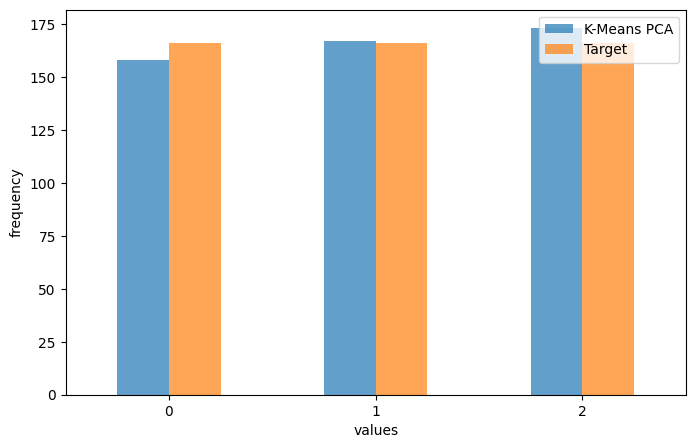

In [346]:
counts_kmeans = df_pca_kmeans['kmeans_pca'].value_counts().sort_index()
counts_target = df_pca_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means PCA': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means PCA", "Target"])
plt.xticks(rotation=0)  
plt.show()


In [347]:
print(confusion_matrix(df_pca_kmeans['target'],df_pca_kmeans['kmeans_pca']))

[[155   1  10]
 [  0 166   0]
 [  3   0 163]]


In [348]:
print(classification_report(df_pca_kmeans['target'],df_pca_kmeans['kmeans_pca']))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       166
           1       0.99      1.00      1.00       166
           2       0.94      0.98      0.96       166

    accuracy                           0.97       498
   macro avg       0.97      0.97      0.97       498
weighted avg       0.97      0.97      0.97       498



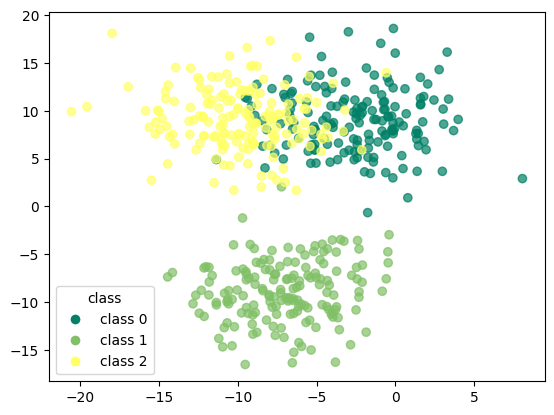

In [349]:
scatter = plt.scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                      c=df_pca_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

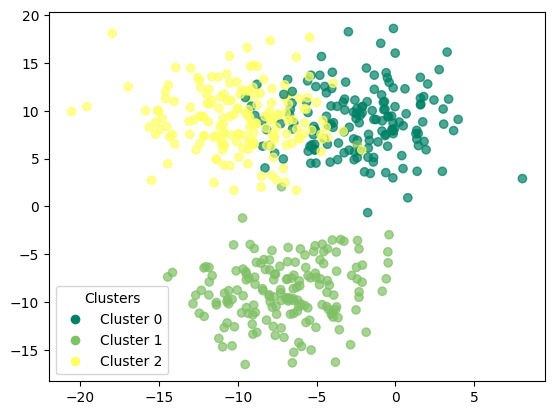

In [350]:
scatter = plt.scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                      c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_kmeans['kmeans_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

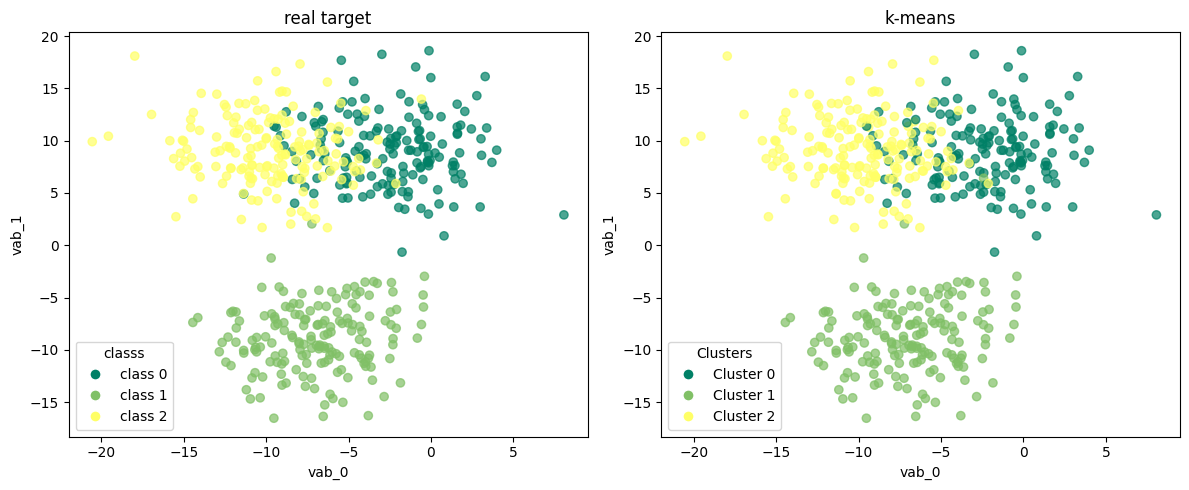

In [351]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                           c=df_pca_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                           c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_kmeans['kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

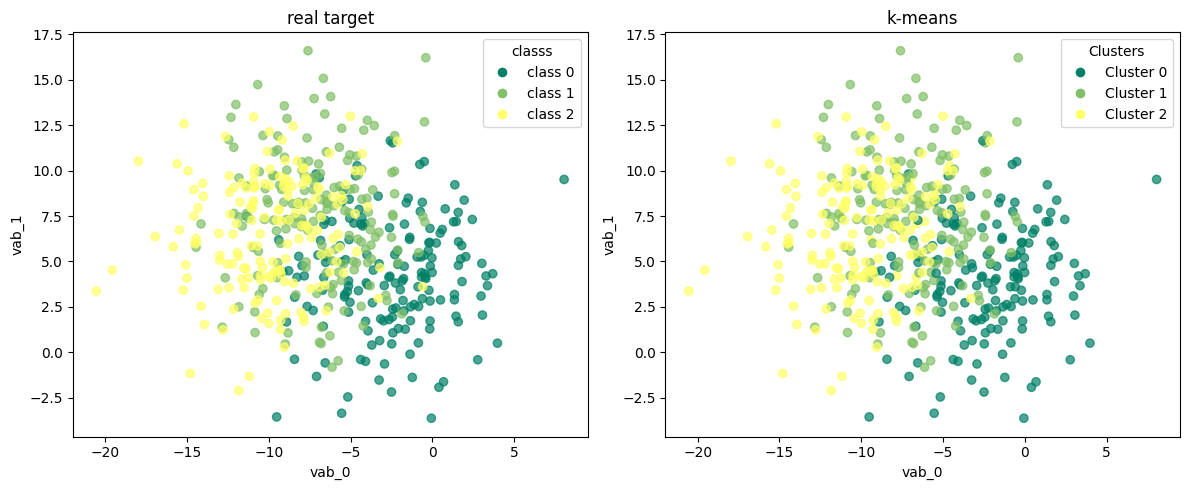

In [352]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 2], 
                           c=df_pca_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 2], 
                           c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_kmeans['kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

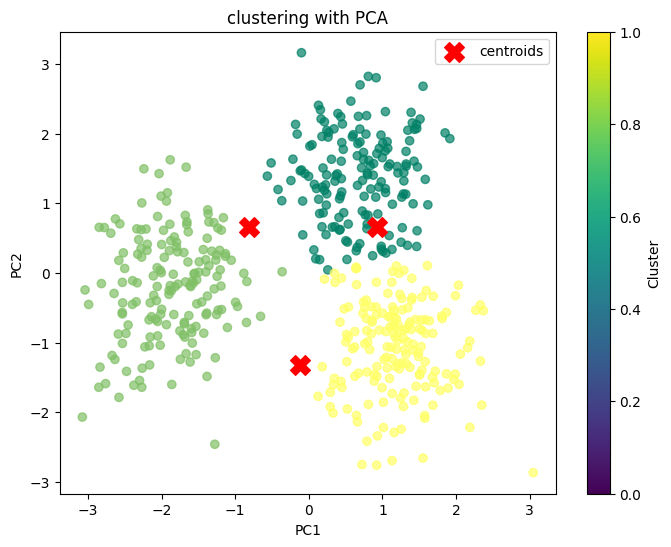

In [353]:
plt.figure(figsize=(8, 6))
plt.scatter(final_df['principal component 1'], final_df['principal component 2'] , c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', marker='X', s=200, label='centroids')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('clustering with PCA')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

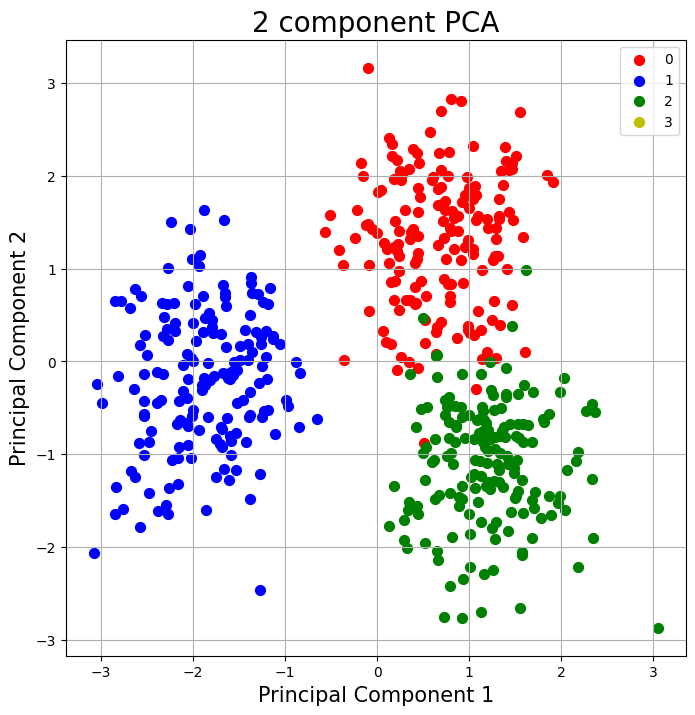

In [354]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1',fontsize = 15)
ax.set_ylabel('Principal Component 2',fontsize = 15)
ax.set_title('2 component PCA',fontsize = 20)

targets = [0,1,2,3]
colors = ['r','b','g','y']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['target'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               ,final_df.loc[indicesToKeep, 'principal component 2']
               ,c = color
               ,s = 50)
ax.legend(targets)
ax.grid()

### k-means with t-SNE

In [355]:
kmeans_tsne = KMeans(n_clusters=3,init='k-means++',random_state=42)

In [356]:
kmeans_tsne.fit(X_tsne)

KMeans(n_clusters=3, random_state=42)

In [357]:
df_tsne_kmeans = corr_dataset.copy()

In [358]:
df_tsne_kmeans['kmeans_tsne'] = kmeans_tsne.labels_

In [359]:
df_tsne_kmeans

vab_1      vab_2     vab_3      vab_4      vab_5  target  kmeans_tsne
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0            2
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0            2
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0            2
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0            1
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0            2
..         ...        ...       ...        ...        ...     ...          ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2            1
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2            1
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2            1
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2            1
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2            1

[498 rows x 7 columns]

In [360]:
y_true = df_tsne_kmeans['target'].values  
y_kmeans = df_tsne_kmeans['kmeans_tsne'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_tsne_kmeans['kmeans_tsne'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_tsne_kmeans['kmeans_tsne'] == y_true))

accuracy before: 0.004016064257028112
accuracy after: 0.9658634538152611


In [361]:
df_tsne_kmeans

vab_1      vab_2     vab_3      vab_4      vab_5  target  kmeans_tsne
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0            0
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0            0
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0            0
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0            2
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0            0
..         ...        ...       ...        ...        ...     ...          ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2            2
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2            2
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2            2
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2            2
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2            2

[498 rows x 7 columns]

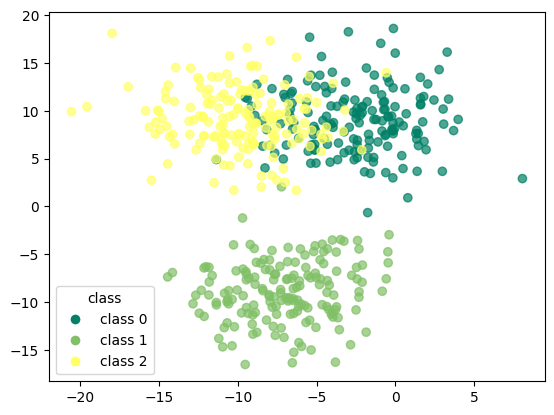

In [362]:
scatter = plt.scatter(df_tsne_kmeans.iloc[:, 0], df_tsne_kmeans.iloc[:, 1], 
                      c=df_tsne_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_tsne_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

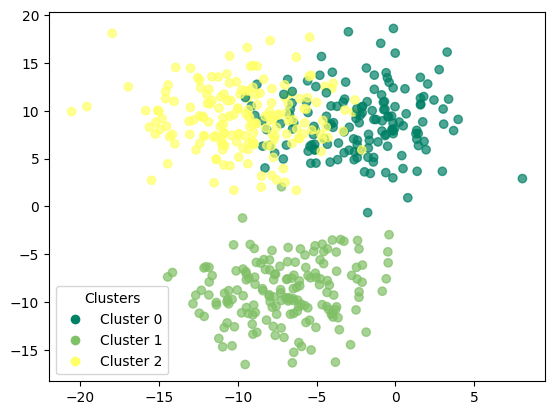

In [363]:
scatter = plt.scatter(df_tsne_kmeans.iloc[:, 0], df_tsne_kmeans.iloc[:, 1], 
                      c=df_tsne_kmeans['kmeans_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_kmeans['kmeans_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

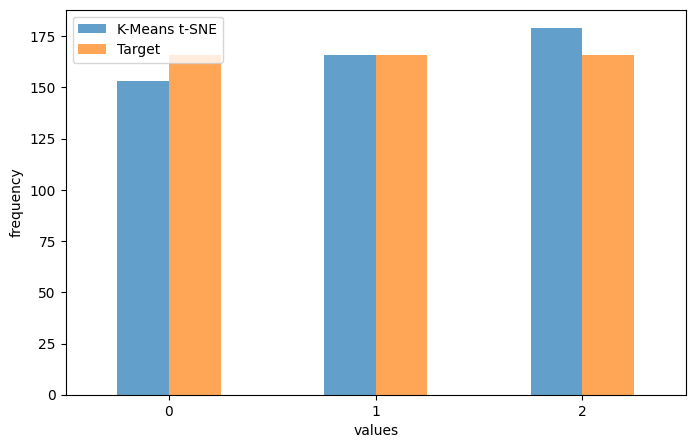

In [364]:
counts_kmeans = df_tsne_kmeans['kmeans_tsne'].value_counts().sort_index()
counts_target = df_tsne_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means t-SNE': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means t-SNE", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [365]:
print(confusion_matrix(df_tsne_kmeans['target'],df_tsne_kmeans['kmeans_tsne']))

[[151   0  15]
 [  0 166   0]
 [  2   0 164]]


In [366]:
print(classification_report(df_tsne_kmeans['target'],df_tsne_kmeans['kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       166
           1       1.00      1.00      1.00       166
           2       0.92      0.99      0.95       166

    accuracy                           0.97       498
   macro avg       0.97      0.97      0.97       498
weighted avg       0.97      0.97      0.97       498



### k-means with umap

In [367]:
kmeans_umap = KMeans(n_clusters=3,init='k-means++',random_state=42)

In [368]:
kmeans_umap.fit(X_umap)

KMeans(n_clusters=3, random_state=42)

In [369]:
df_umap_kmeans = corr_dataset.copy()

In [370]:
df_umap_kmeans['kmeans_umap'] = kmeans_umap.labels_

In [371]:
df_umap_kmeans

vab_1      vab_2     vab_3      vab_4      vab_5  target  kmeans_umap
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0            2
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0            2
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0            2
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0            2
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0            2
..         ...        ...       ...        ...        ...     ...          ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2            1
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2            1
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2            1
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2            1
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2            1

[498 rows x 7 columns]

In [372]:
y_true = df_umap_kmeans['target'].values  
y_kmeans = df_umap_kmeans['kmeans_umap'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_umap_kmeans['kmeans_umap'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_umap_kmeans['kmeans_umap'] == y_true))

accuracy before: 0.018072289156626505
accuracy after: 0.9779116465863453


In [373]:
df_umap_kmeans

vab_1      vab_2     vab_3      vab_4      vab_5  target  kmeans_umap
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0            0
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0            0
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0            0
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0            0
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0            0
..         ...        ...       ...        ...        ...     ...          ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2            2
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2            2
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2            2
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2            2
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2            2

[498 rows x 7 columns]

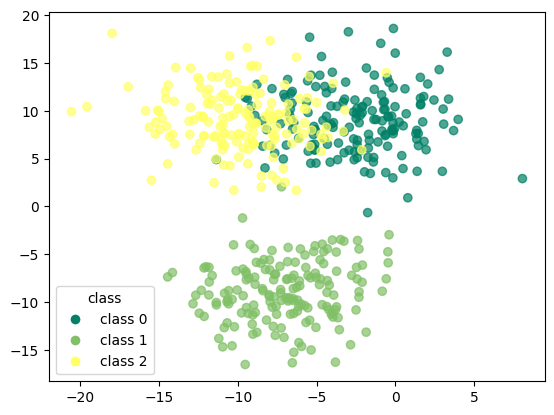

In [374]:
scatter = plt.scatter(df_umap_kmeans.iloc[:, 0], df_umap_kmeans.iloc[:, 1], 
                      c=df_umap_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_umap_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

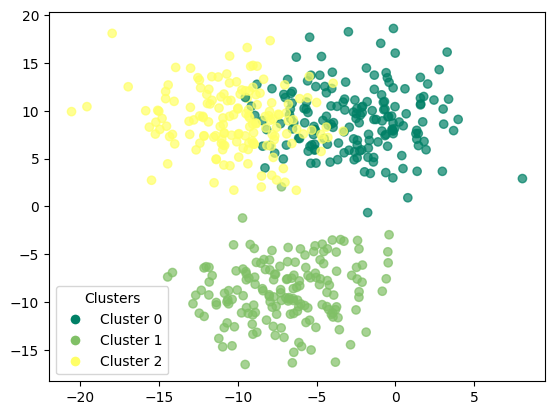

In [375]:
scatter = plt.scatter(df_umap_kmeans.iloc[:, 0], df_umap_kmeans.iloc[:, 1], 
                      c=df_umap_kmeans['kmeans_umap'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_umap_kmeans['kmeans_umap'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

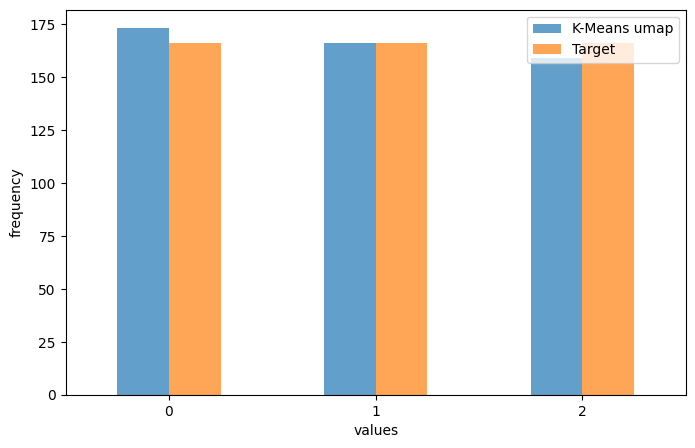

In [376]:
counts_kmeans = df_umap_kmeans['kmeans_umap'].value_counts().sort_index()
counts_target = df_umap_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means umap': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means umap", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [377]:
print(confusion_matrix(df_umap_kmeans['target'],df_umap_kmeans['kmeans_umap']))

[[164   0   2]
 [  0 166   0]
 [  9   0 157]]


In [378]:
print(classification_report(df_umap_kmeans['target'],df_umap_kmeans['kmeans_umap'])) 

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       166
           1       1.00      1.00      1.00       166
           2       0.99      0.95      0.97       166

    accuracy                           0.98       498
   macro avg       0.98      0.98      0.98       498
weighted avg       0.98      0.98      0.98       498



## trimmed k-means

In [379]:
def trimmed_clustering(X,n_clusters,trim_fraction=0.1):

    kmeans = KMeans(n_clusters=n_clusters,random_state=42).fit(X)
    distances = np.min(kmeans.transform(X),axis=1)
    
    trim_threshold = np.percentile(distances,100 * (1 - trim_fraction))
    trimmed_X = X[distances < trim_threshold]
    trimmed_indices = np.where(distances < trim_threshold)[0]
    trimmed_kmeans = KMeans(n_clusters=n_clusters,random_state=42).fit(trimmed_X)
    
    return trimmed_kmeans,trimmed_indices

In [380]:
trimmed_kmeans,trimmmed_indces = trimmed_clustering(X_values,n_clusters=3,trim_fraction=0.1)

In [381]:
trimmed_kmeans

KMeans(n_clusters=3, random_state=42)

In [382]:
df_trim_kmeans = corr_dataset.copy()

In [383]:
df_trim_kmeans = df_trim_kmeans.iloc[trimmmed_indces]  

In [384]:
df_trim_kmeans['trim_kmeans'] = trimmed_kmeans.labels_

In [385]:
df_trim_kmeans

vab_1      vab_2     vab_3     vab_4      vab_5  target  trim_kmeans
0    -2.939361   5.873120  3.670536  5.408232 -10.192434       0            2
1     1.354261   7.949398  2.886259  4.430629  -5.424494       0            2
2    -0.871902  11.659821  3.602247  2.559085 -10.689767       0            2
3    -5.438331  17.682938  8.916168 -0.225324 -10.825169       0            1
4    -2.103619   9.789868  4.839907  1.572048  -8.563410       0            2
..         ...        ...       ...       ...        ...     ...          ...
492  -8.358945  13.290048  7.655134 -2.560879  -5.345675       2            1
493 -14.939035   8.044888  9.980991 -6.578398  -5.221839       2            1
494  -9.337069   5.945577  4.507455 -5.357300 -10.264729       2            1
495 -10.952899   5.924296  8.206560 -6.229156  -1.637876       2            1
497 -14.575097  12.013696  7.495777 -4.168611 -14.307099       2            1

[448 rows x 7 columns]

In [386]:
y_true = df_trim_kmeans['target'].values  
y_kmeans = df_trim_kmeans['trim_kmeans'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_trim_kmeans['trim_kmeans'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_trim_kmeans['trim_kmeans'] == y_true))

accuracy before: 0.006696428571428571
accuracy after: 0.9709821428571429


In [387]:
df_trim_kmeans

vab_1      vab_2     vab_3     vab_4      vab_5  target  trim_kmeans
0    -2.939361   5.873120  3.670536  5.408232 -10.192434       0            0
1     1.354261   7.949398  2.886259  4.430629  -5.424494       0            0
2    -0.871902  11.659821  3.602247  2.559085 -10.689767       0            0
3    -5.438331  17.682938  8.916168 -0.225324 -10.825169       0            2
4    -2.103619   9.789868  4.839907  1.572048  -8.563410       0            0
..         ...        ...       ...       ...        ...     ...          ...
492  -8.358945  13.290048  7.655134 -2.560879  -5.345675       2            2
493 -14.939035   8.044888  9.980991 -6.578398  -5.221839       2            2
494  -9.337069   5.945577  4.507455 -5.357300 -10.264729       2            2
495 -10.952899   5.924296  8.206560 -6.229156  -1.637876       2            2
497 -14.575097  12.013696  7.495777 -4.168611 -14.307099       2            2

[448 rows x 7 columns]

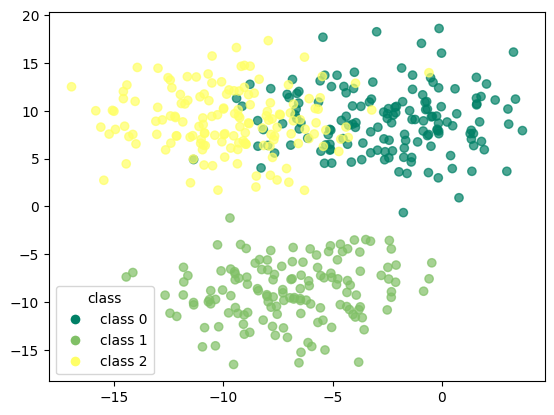

In [388]:
scatter = plt.scatter(df_trim_kmeans.iloc[:, 0], df_trim_kmeans.iloc[:, 1], 
                      c=df_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_trim_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

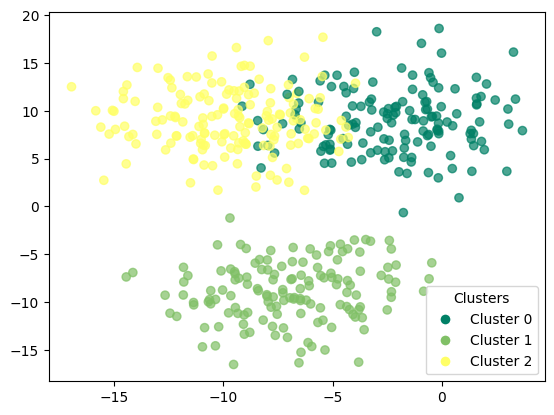

In [389]:
scatter = plt.scatter(df_trim_kmeans.iloc[:, 0], df_trim_kmeans.iloc[:, 1], 
                      c=df_trim_kmeans['trim_kmeans'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_trim_kmeans['trim_kmeans'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [390]:
print(confusion_matrix(df_trim_kmeans['target'],df_trim_kmeans['trim_kmeans']))

[[144   0  10]
 [  0 142   0]
 [  3   0 149]]


In [391]:
print(classification_report(df_trim_kmeans['target'],df_trim_kmeans['trim_kmeans']))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       154
           1       1.00      1.00      1.00       142
           2       0.94      0.98      0.96       152

    accuracy                           0.97       448
   macro avg       0.97      0.97      0.97       448
weighted avg       0.97      0.97      0.97       448



### trimmed k-means with pca

In [392]:
trim_kmeans_pca,trimmmed_indices = trimmed_clustering(scores_pca,n_clusters=3,trim_fraction=0.1)

In [393]:
trim_kmeans_pca

KMeans(n_clusters=3, random_state=42)

In [394]:
df_pca_trim_kmeans = corr_dataset.copy()

In [395]:
df_pca_trim_kmeans = df_pca_trim_kmeans.iloc[trimmmed_indces]  

In [396]:
df_pca_trim_kmeans["trim_kmeans_pca"] = trim_kmeans_pca.labels_

In [397]:
df_pca_trim_kmeans

vab_1      vab_2     vab_3     vab_4      vab_5  target  \
0    -2.939361   5.873120  3.670536  5.408232 -10.192434       0   
1     1.354261   7.949398  2.886259  4.430629  -5.424494       0   
2    -0.871902  11.659821  3.602247  2.559085 -10.689767       0   
3    -5.438331  17.682938  8.916168 -0.225324 -10.825169       0   
4    -2.103619   9.789868  4.839907  1.572048  -8.563410       0   
..         ...        ...       ...       ...        ...     ...   
492  -8.358945  13.290048  7.655134 -2.560879  -5.345675       2   
493 -14.939035   8.044888  9.980991 -6.578398  -5.221839       2   
494  -9.337069   5.945577  4.507455 -5.357300 -10.264729       2   
495 -10.952899   5.924296  8.206560 -6.229156  -1.637876       2   
497 -14.575097  12.013696  7.495777 -4.168611 -14.307099       2   

     trim_kmeans_pca  
0                  2  
1                  2  
2                  2  
3                  1  
4                  2  
..               ...  
492                1  
493                1  
494                1  
495                1  
497                1  

[448 rows x 7 columns]

In [398]:
y_true = df_pca_trim_kmeans['target'].values  
y_kmeans = df_pca_trim_kmeans['trim_kmeans_pca'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_pca_trim_kmeans['trim_kmeans_pca'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_pca_trim_kmeans['trim_kmeans_pca'] == y_true))

accuracy before: 0.008928571428571428
accuracy after: 0.9754464285714286


In [399]:
df_pca_trim_kmeans

vab_1      vab_2     vab_3     vab_4      vab_5  target  \
0    -2.939361   5.873120  3.670536  5.408232 -10.192434       0   
1     1.354261   7.949398  2.886259  4.430629  -5.424494       0   
2    -0.871902  11.659821  3.602247  2.559085 -10.689767       0   
3    -5.438331  17.682938  8.916168 -0.225324 -10.825169       0   
4    -2.103619   9.789868  4.839907  1.572048  -8.563410       0   
..         ...        ...       ...       ...        ...     ...   
492  -8.358945  13.290048  7.655134 -2.560879  -5.345675       2   
493 -14.939035   8.044888  9.980991 -6.578398  -5.221839       2   
494  -9.337069   5.945577  4.507455 -5.357300 -10.264729       2   
495 -10.952899   5.924296  8.206560 -6.229156  -1.637876       2   
497 -14.575097  12.013696  7.495777 -4.168611 -14.307099       2   

     trim_kmeans_pca  
0                  0  
1                  0  
2                  0  
3                  2  
4                  0  
..               ...  
492                2  
493                2  
494                2  
495                2  
497                2  

[448 rows x 7 columns]

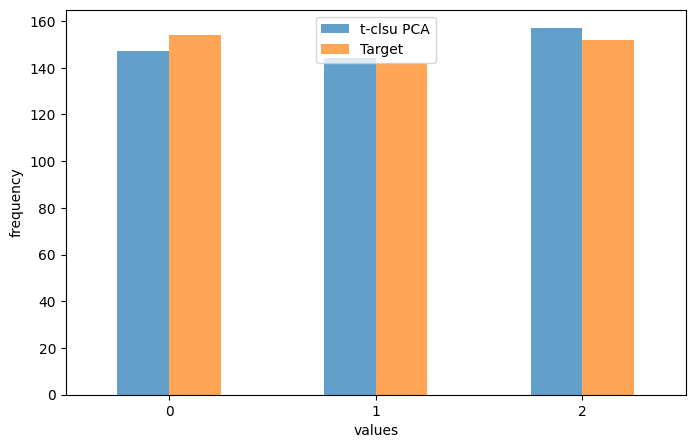

In [400]:
counts_kmeans = df_pca_trim_kmeans['trim_kmeans_pca'].value_counts().sort_index()
counts_target = df_pca_trim_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'t-clust PCA': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["t-clsu PCA", "Target"])
plt.xticks(rotation=0)  
plt.show()


In [401]:
print(confusion_matrix(df_pca_trim_kmeans['target'],df_pca_trim_kmeans['trim_kmeans_pca']))

[[145   2   7]
 [  0 142   0]
 [  2   0 150]]


In [402]:
print(classification_report(df_pca_trim_kmeans['target'],df_pca_trim_kmeans['trim_kmeans_pca']))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       154
           1       0.99      1.00      0.99       142
           2       0.96      0.99      0.97       152

    accuracy                           0.98       448
   macro avg       0.98      0.98      0.98       448
weighted avg       0.98      0.98      0.98       448



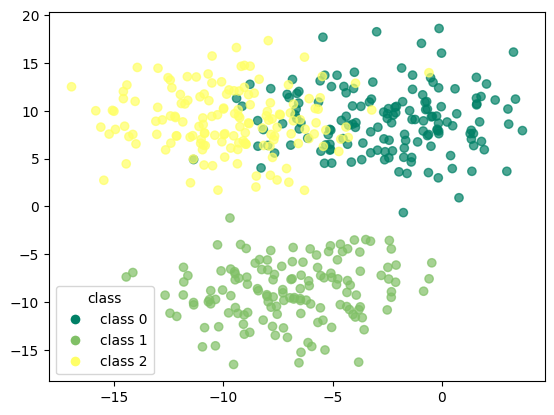

In [403]:
scatter = plt.scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 1], 
                      c=df_pca_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_trim_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

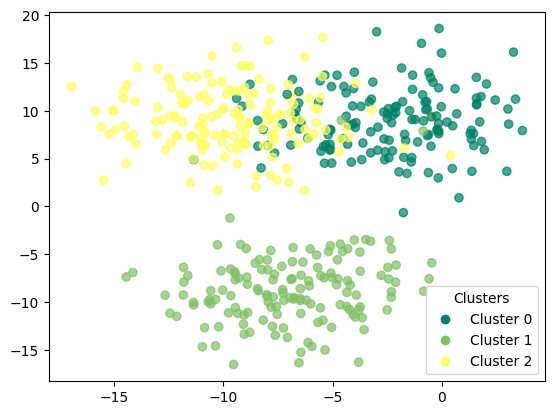

In [404]:
scatter = plt.scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 1], 
                      c=df_pca_trim_kmeans['trim_kmeans_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_trim_kmeans['trim_kmeans_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

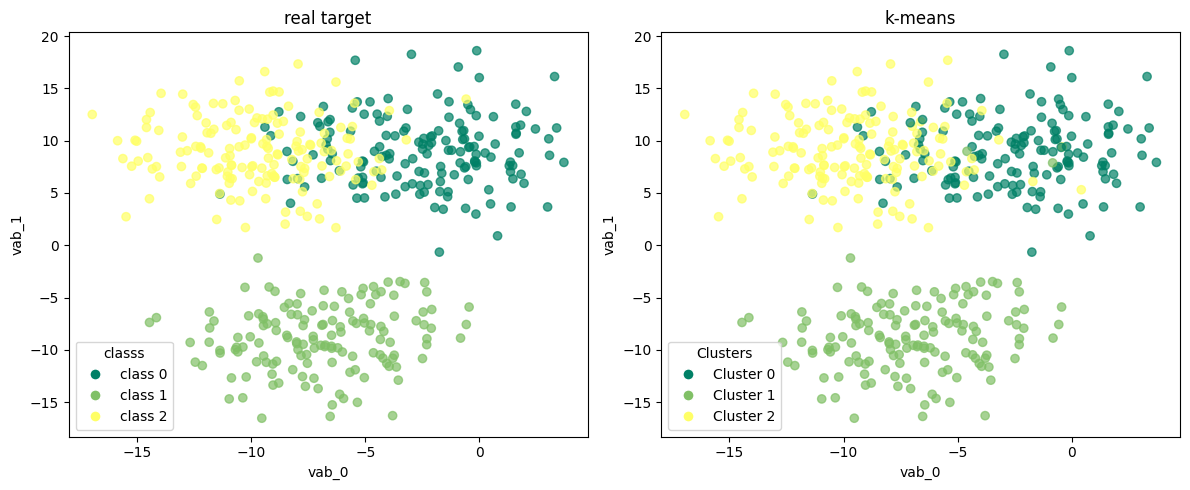

In [405]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 1], 
                           c=df_pca_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_trim_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 1], 
                           c=df_pca_trim_kmeans['trim_kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_trim_kmeans['trim_kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

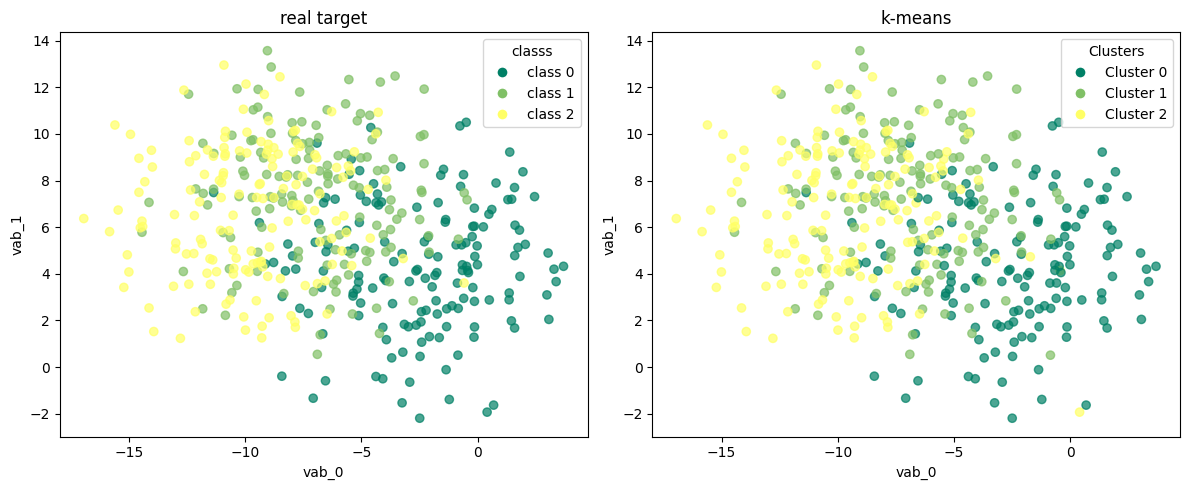

In [406]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 2], 
                           c=df_pca_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_trim_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 2], 
                           c=df_pca_trim_kmeans['trim_kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_trim_kmeans['trim_kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

### trimmed k-means with t-SNE

In [407]:
trim_kmeans_tsne,trimmmed_indices = trimmed_clustering(X_tsne,n_clusters=3,trim_fraction=0.1)

In [408]:
trim_kmeans_tsne

KMeans(n_clusters=3, random_state=42)

In [409]:
df_tsne_trim_kmeans = corr_dataset.copy()

In [410]:
df_tsne_trim_kmeans = df_tsne_trim_kmeans.iloc[trimmmed_indces]  

In [411]:
df_tsne_trim_kmeans['trim_kmeans_tsne'] = trim_kmeans_tsne.labels_

In [412]:
df_tsne_trim_kmeans

vab_1      vab_2     vab_3     vab_4      vab_5  target  \
0    -2.939361   5.873120  3.670536  5.408232 -10.192434       0   
1     1.354261   7.949398  2.886259  4.430629  -5.424494       0   
2    -0.871902  11.659821  3.602247  2.559085 -10.689767       0   
3    -5.438331  17.682938  8.916168 -0.225324 -10.825169       0   
4    -2.103619   9.789868  4.839907  1.572048  -8.563410       0   
..         ...        ...       ...       ...        ...     ...   
492  -8.358945  13.290048  7.655134 -2.560879  -5.345675       2   
493 -14.939035   8.044888  9.980991 -6.578398  -5.221839       2   
494  -9.337069   5.945577  4.507455 -5.357300 -10.264729       2   
495 -10.952899   5.924296  8.206560 -6.229156  -1.637876       2   
497 -14.575097  12.013696  7.495777 -4.168611 -14.307099       2   

     trim_kmeans_tsne  
0                   2  
1                   2  
2                   2  
3                   1  
4                   2  
..                ...  
492                 1  
493                 1  
494                 1  
495                 1  
497                 1  

[448 rows x 7 columns]

In [413]:
y_true = df_tsne_trim_kmeans['target'].values  
y_kmeans = df_tsne_trim_kmeans['trim_kmeans_tsne'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_tsne_trim_kmeans['trim_kmeans_tsne'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_tsne_trim_kmeans['trim_kmeans_tsne'] == y_true))

accuracy before: 0.008928571428571428
accuracy after: 0.9620535714285714


In [414]:
df_tsne_trim_kmeans

vab_1      vab_2     vab_3     vab_4      vab_5  target  \
0    -2.939361   5.873120  3.670536  5.408232 -10.192434       0   
1     1.354261   7.949398  2.886259  4.430629  -5.424494       0   
2    -0.871902  11.659821  3.602247  2.559085 -10.689767       0   
3    -5.438331  17.682938  8.916168 -0.225324 -10.825169       0   
4    -2.103619   9.789868  4.839907  1.572048  -8.563410       0   
..         ...        ...       ...       ...        ...     ...   
492  -8.358945  13.290048  7.655134 -2.560879  -5.345675       2   
493 -14.939035   8.044888  9.980991 -6.578398  -5.221839       2   
494  -9.337069   5.945577  4.507455 -5.357300 -10.264729       2   
495 -10.952899   5.924296  8.206560 -6.229156  -1.637876       2   
497 -14.575097  12.013696  7.495777 -4.168611 -14.307099       2   

     trim_kmeans_tsne  
0                   0  
1                   0  
2                   0  
3                   2  
4                   0  
..                ...  
492                 2  
493                 2  
494                 2  
495                 2  
497                 2  

[448 rows x 7 columns]

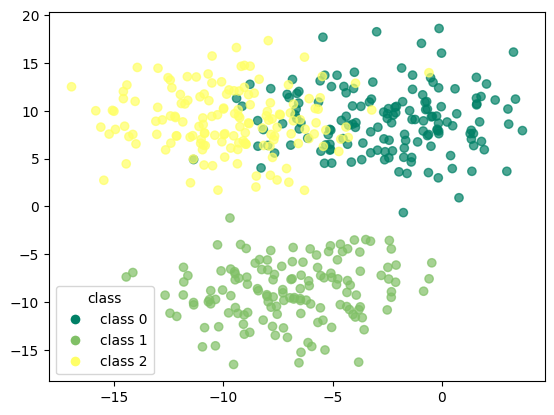

In [415]:
scatter = plt.scatter(df_tsne_trim_kmeans.iloc[:, 0], df_tsne_trim_kmeans.iloc[:, 1], 
                      c=df_tsne_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_tsne_trim_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

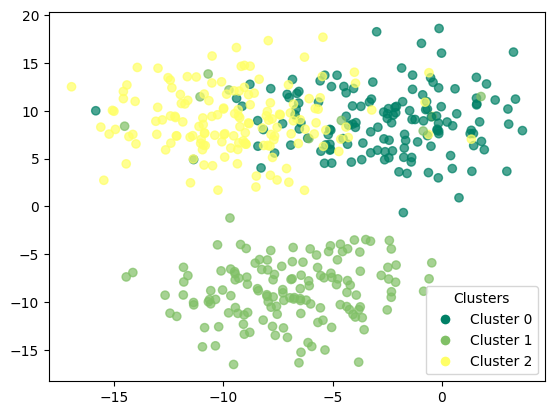

In [416]:
scatter = plt.scatter(df_tsne_trim_kmeans.iloc[:, 0], df_tsne_trim_kmeans.iloc[:, 1], 
                      c=df_tsne_trim_kmeans['trim_kmeans_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_trim_kmeans['trim_kmeans_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

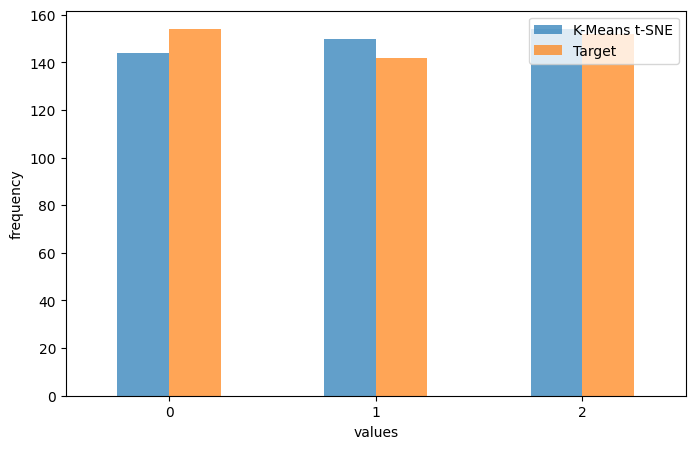

In [417]:
counts_kmeans = df_tsne_trim_kmeans['trim_kmeans_tsne'].value_counts().sort_index()
counts_target = df_tsne_trim_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means t-SNE': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means t-SNE", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [418]:
print(confusion_matrix(df_tsne_trim_kmeans['target'],df_tsne_trim_kmeans['trim_kmeans_tsne']))

[[143   3   8]
 [  0 142   0]
 [  1   5 146]]


In [419]:
print(classification_report(df_tsne_trim_kmeans['target'],df_tsne_trim_kmeans['trim_kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       154
           1       0.95      1.00      0.97       142
           2       0.95      0.96      0.95       152

    accuracy                           0.96       448
   macro avg       0.96      0.96      0.96       448
weighted avg       0.96      0.96      0.96       448



### trimmed k-means with umap

In [420]:
trim_kmeans_umap,trimmmed_indices = trimmed_clustering(X_umap,n_clusters=3,trim_fraction=0.1)

In [421]:
trim_kmeans_umap

KMeans(n_clusters=3, random_state=42)

In [422]:
df_umap_trim_kmeans = corr_dataset.copy()

In [423]:
df_umap_trim_kmeans = df_umap_trim_kmeans.iloc[trimmmed_indices]

In [424]:
df_umap_trim_kmeans['trim_kmeans_umap'] = trim_kmeans_umap.labels_

In [425]:
df_umap_trim_kmeans

vab_1      vab_2     vab_3     vab_4      vab_5  target  \
0    -2.939361   5.873120  3.670536  5.408232 -10.192434       0   
1     1.354261   7.949398  2.886259  4.430629  -5.424494       0   
2    -0.871902  11.659821  3.602247  2.559085 -10.689767       0   
3    -5.438331  17.682938  8.916168 -0.225324 -10.825169       0   
4    -2.103619   9.789868  4.839907  1.572048  -8.563410       0   
..         ...        ...       ...       ...        ...     ...   
490  -7.982090   9.916766  6.975848 -7.077864  -0.462286       2   
493 -14.939035   8.044888  9.980991 -6.578398  -5.221839       2   
494  -9.337069   5.945577  4.507455 -5.357300 -10.264729       2   
495 -10.952899   5.924296  8.206560 -6.229156  -1.637876       2   
497 -14.575097  12.013696  7.495777 -4.168611 -14.307099       2   

     trim_kmeans_umap  
0                   2  
1                   2  
2                   2  
3                   2  
4                   2  
..                ...  
490                 1  
493                 1  
494                 1  
495                 1  
497                 1  

[448 rows x 7 columns]

In [426]:
y_true = df_umap_trim_kmeans['target'].values  
y_kmeans = df_umap_trim_kmeans['trim_kmeans_umap'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_umap_trim_kmeans['trim_kmeans_umap'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_umap_trim_kmeans['trim_kmeans_umap'] == y_true))

accuracy before: 0.004464285714285714
accuracy after: 0.9933035714285714


In [427]:
df_umap_trim_kmeans

vab_1      vab_2     vab_3     vab_4      vab_5  target  \
0    -2.939361   5.873120  3.670536  5.408232 -10.192434       0   
1     1.354261   7.949398  2.886259  4.430629  -5.424494       0   
2    -0.871902  11.659821  3.602247  2.559085 -10.689767       0   
3    -5.438331  17.682938  8.916168 -0.225324 -10.825169       0   
4    -2.103619   9.789868  4.839907  1.572048  -8.563410       0   
..         ...        ...       ...       ...        ...     ...   
490  -7.982090   9.916766  6.975848 -7.077864  -0.462286       2   
493 -14.939035   8.044888  9.980991 -6.578398  -5.221839       2   
494  -9.337069   5.945577  4.507455 -5.357300 -10.264729       2   
495 -10.952899   5.924296  8.206560 -6.229156  -1.637876       2   
497 -14.575097  12.013696  7.495777 -4.168611 -14.307099       2   

     trim_kmeans_umap  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
490                 2  
493                 2  
494                 2  
495                 2  
497                 2  

[448 rows x 7 columns]

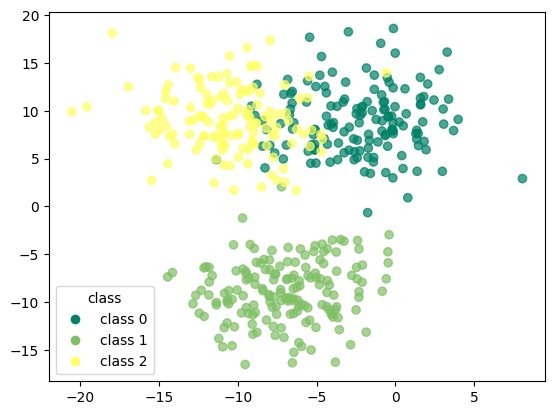

In [428]:
scatter = plt.scatter(df_umap_trim_kmeans.iloc[:, 0], df_umap_trim_kmeans.iloc[:, 1], 
                      c=df_umap_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_umap_trim_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

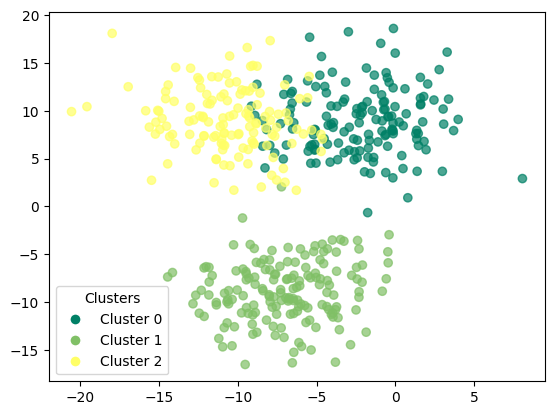

In [429]:
scatter = plt.scatter(df_umap_trim_kmeans.iloc[:, 0], df_umap_trim_kmeans.iloc[:, 1], 
                      c=df_umap_trim_kmeans['trim_kmeans_umap'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_umap_trim_kmeans['trim_kmeans_umap'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

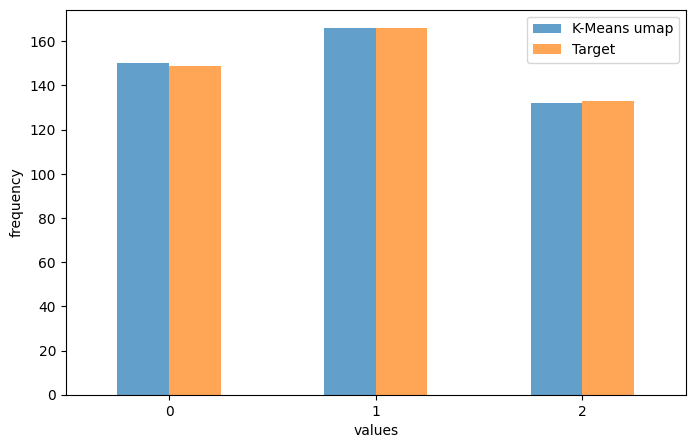

In [430]:
counts_kmeans = df_umap_trim_kmeans['trim_kmeans_umap'].value_counts().sort_index()
counts_target = df_umap_trim_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means umap': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means umap", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [431]:
print(confusion_matrix(df_umap_trim_kmeans['target'],df_umap_trim_kmeans['trim_kmeans_umap']))

[[148   0   1]
 [  0 166   0]
 [  2   0 131]]


In [432]:
print(classification_report(df_umap_trim_kmeans['target'],df_umap_trim_kmeans['trim_kmeans_umap'])) 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       149
           1       1.00      1.00      1.00       166
           2       0.99      0.98      0.99       133

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



## dbscan

In [433]:
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.show()

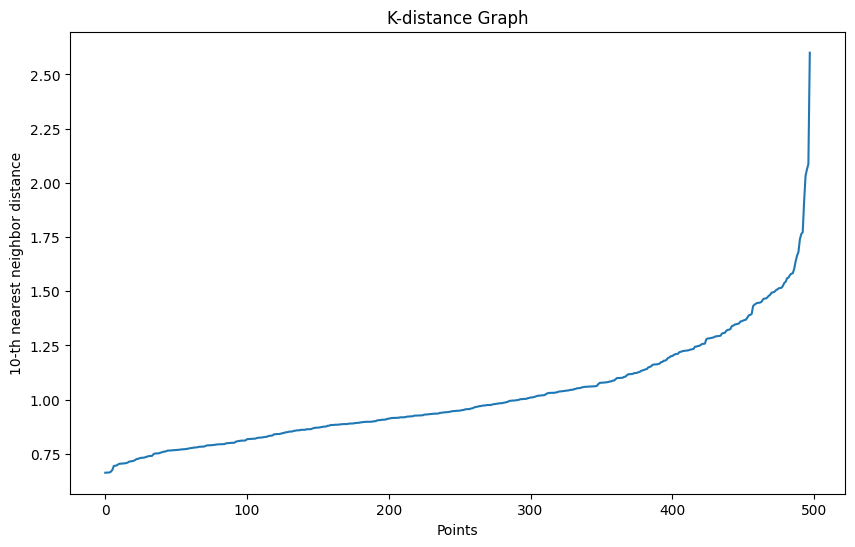

In [434]:
plot_k_distance_graph(X_values,k=10) 

In [435]:
dbscan = DBSCAN(eps=0.9,min_samples=10) # min_samples = 2*n_features

In [436]:
dbscan.fit(X_values)

DBSCAN(eps=0.9, min_samples=10)

In [437]:
df_dbscan = corr_dataset.copy()

In [438]:
df_dbscan['dbscan'] = dbscan.labels_

In [439]:
y_true = df_dbscan['target'].values  
y_kmeans = df_dbscan['dbscan'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_dbscan['dbscan'] = np.array([mapping[label] if label in mapping else -1 for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_dbscan['dbscan'] == y_true))

accuracy before: 0.5
accuracy after: 0.0


In [440]:
df_dbscan

vab_1      vab_2     vab_3      vab_4      vab_5  target  dbscan
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0       1
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0       1
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0       1
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0      -1
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0       1
..         ...        ...       ...        ...        ...     ...     ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2      -1
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2       1
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2       1
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2      -1
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2       1

[498 rows x 7 columns]

In [441]:
print(df_dbscan['dbscan'].value_counts())

dbscan
 1    270
 3    116
-1    112
Name: count, dtype: int64


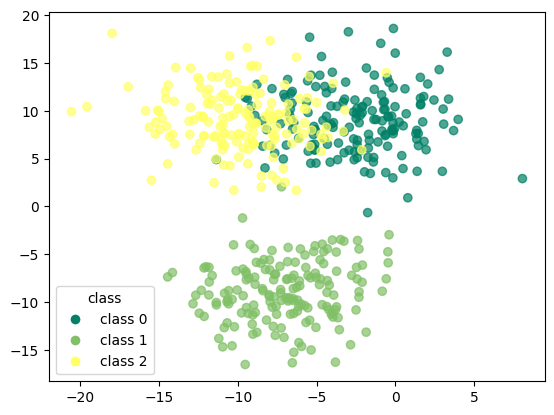

In [442]:
scatter = plt.scatter(df_dbscan.iloc[:, 0], df_dbscan.iloc[:, 1], 
                      c=df_dbscan['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_dbscan['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

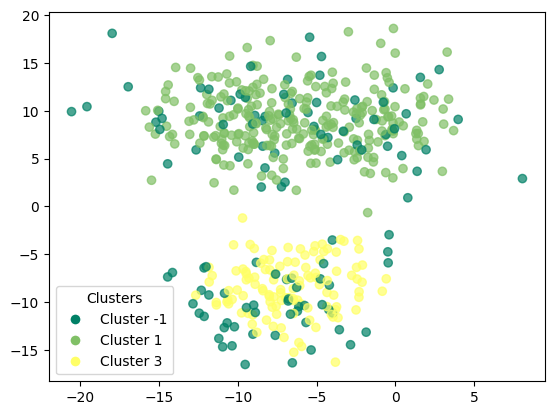

In [443]:
scatter = plt.scatter(df_dbscan.iloc[:, 0], df_dbscan.iloc[:, 1], 
                      c=df_dbscan['dbscan'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_dbscan['dbscan'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [444]:
print(confusion_matrix(df_dbscan['target'],df_dbscan['dbscan']))

[[  0   0   0   0   0]
 [ 33   0 133   0   0]
 [ 50   0   0   0 116]
 [ 29   0 137   0   0]
 [  0   0   0   0   0]]


In [445]:
print(classification_report(df_dbscan['target'],df_dbscan['dbscan']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       0.0
           0       0.00      0.00      0.00     166.0
           1       0.00      0.00      0.00     166.0
           2       0.00      0.00      0.00     166.0
           3       0.00      0.00      0.00       0.0

    accuracy                           0.00     498.0
   macro avg       0.00      0.00      0.00     498.0
weighted avg       0.00      0.00      0.00     498.0



### dbscan with pca

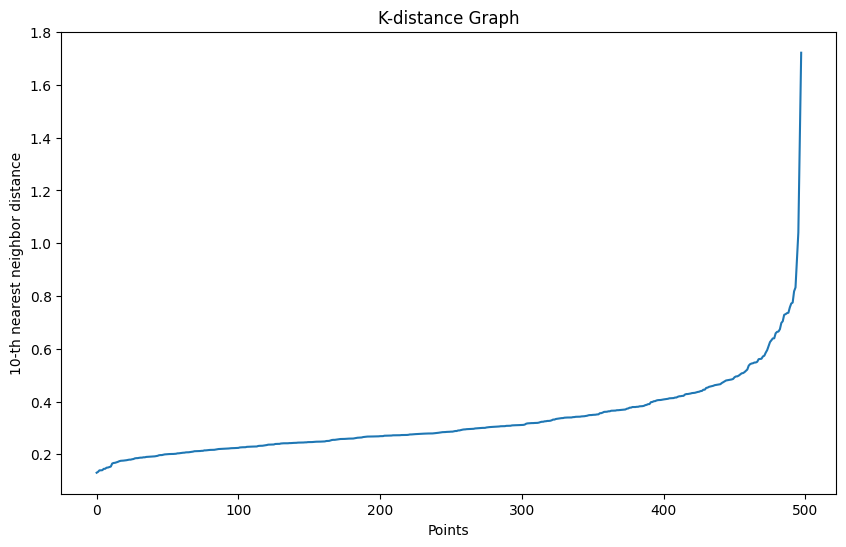

In [446]:
plot_k_distance_graph(scores_pca,k=10)

In [447]:
dbscan_pca = DBSCAN(eps=0.4,min_samples=10)

In [448]:
dbscan_pca.fit(scores_pca)

DBSCAN(eps=0.4, min_samples=10)

In [449]:
df_pca_dbscan = corr_dataset.copy()

In [450]:
df_pca_dbscan["dbscan_pca"] = dbscan_pca.labels_

In [451]:
y_true = df_pca_dbscan['target'].values  
y_kmeans = df_pca_dbscan['dbscan_pca'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_pca_dbscan['dbscan_pca'] = np.array([mapping[label] if label in mapping else -1 for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_pca_dbscan['dbscan_pca'] == y_true))

accuracy before: 0.6164658634538153
accuracy after: 0.2971887550200803


In [452]:
df_pca_dbscan

vab_1      vab_2     vab_3      vab_4      vab_5  target  dbscan_pca
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0           3
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0           3
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0           3
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0           3
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0           3
..         ...        ...       ...        ...        ...     ...         ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2          -1
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2           3
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2           3
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2           3
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2           3

[498 rows x 7 columns]

In [453]:
print(df_pca_dbscan['dbscan_pca'].value_counts())

dbscan_pca
 3    309
 1    148
-1     33
 2      8
Name: count, dtype: int64


In [454]:
print(confusion_matrix(df_pca_dbscan['target'],df_pca_dbscan['dbscan_pca']))

[[  0   0   0   0   0]
 [  7   0   0   0 159]
 [ 10   0 148   8   0]
 [ 16   0   0   0 150]
 [  0   0   0   0   0]]


In [455]:
print(classification_report(df_pca_dbscan['target'],df_pca_dbscan['dbscan_pca']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       166
           1       1.00      0.89      0.94       166
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00         0

    accuracy                           0.30       498
   macro avg       0.20      0.18      0.19       498
weighted avg       0.33      0.30      0.31       498



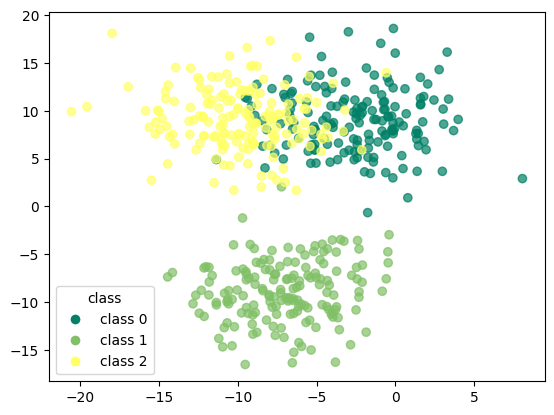

In [456]:
scatter = plt.scatter(df_pca_dbscan.iloc[:, 0], df_pca_dbscan.iloc[:, 1], 
                      c=df_pca_dbscan['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_dbscan['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

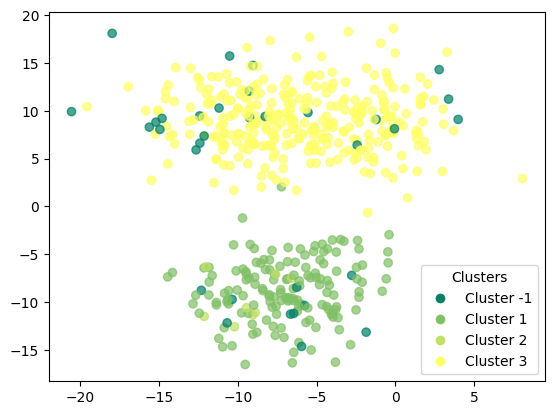

In [457]:
scatter = plt.scatter(df_pca_dbscan.iloc[:, 0], df_pca_dbscan.iloc[:, 1], 
                      c=df_pca_dbscan['dbscan_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_dbscan['dbscan_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

### dbscan with t-SNE

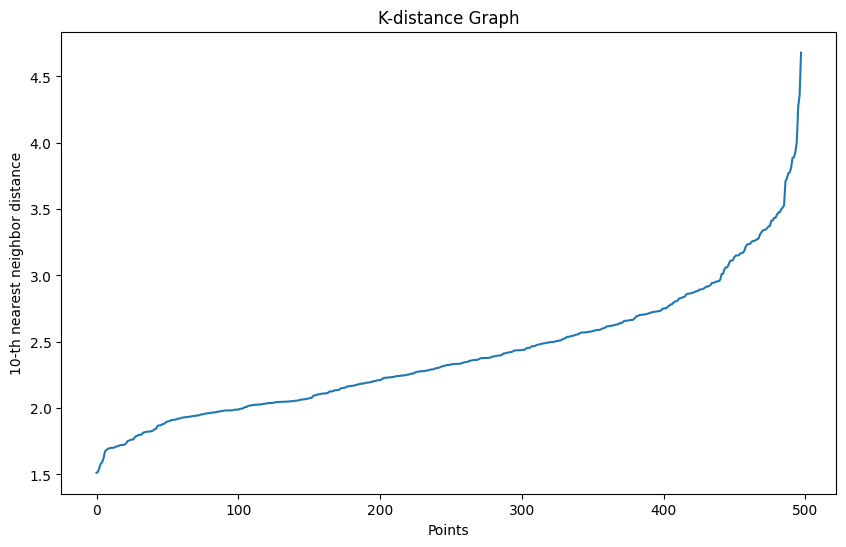

In [458]:
plot_k_distance_graph(X_tsne,k=10)

In [459]:
dbscan_tsne = DBSCAN(eps=3,min_samples=10)

In [460]:
dbscan_tsne.fit(X_tsne)

DBSCAN(eps=3, min_samples=10)

In [461]:
df_tsne_dbscan = corr_dataset.copy()

In [462]:
df_tsne_dbscan['dbscan_tsne'] = dbscan_tsne.labels_

In [463]:
y_true = df_tsne_dbscan['target'].values  
y_kmeans = df_tsne_dbscan['dbscan_tsne'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_tsne_dbscan['dbscan_tsne'] = np.array([mapping[label] if label in mapping else -1 for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_tsne_dbscan['dbscan_tsne'] == y_true))

accuracy before: 0.6666666666666666
accuracy after: 0.6666666666666666


In [464]:
df_tsne_dbscan

vab_1      vab_2     vab_3      vab_4      vab_5  target  dbscan_tsne
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0            0
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0            0
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0            0
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0            0
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0            0
..         ...        ...       ...        ...        ...     ...          ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2            0
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2            0
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2            0
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2            0
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2            0

[498 rows x 7 columns]

In [465]:
print(df_tsne_dbscan['dbscan_tsne'].value_counts())

dbscan_tsne
0    332
1    166
Name: count, dtype: int64


In [466]:
print(confusion_matrix(df_tsne_dbscan['target'],df_tsne_dbscan['dbscan_tsne']))

[[166   0   0]
 [  0 166   0]
 [166   0   0]]


In [467]:
print(classification_report(df_tsne_dbscan['target'],df_tsne_dbscan['dbscan_tsne']))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       166
           1       1.00      1.00      1.00       166
           2       0.00      0.00      0.00       166

    accuracy                           0.67       498
   macro avg       0.50      0.67      0.56       498
weighted avg       0.50      0.67      0.56       498



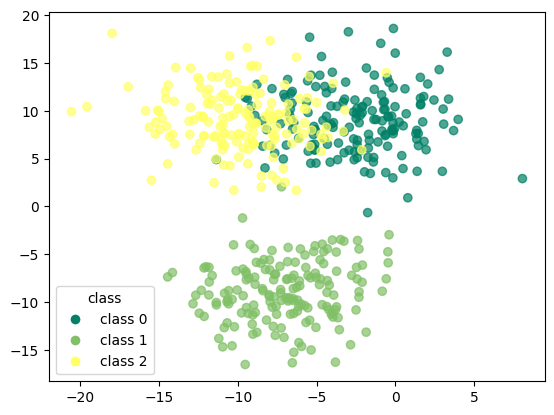

In [468]:
scatter = plt.scatter(df_tsne_dbscan.iloc[:, 0], df_tsne_dbscan.iloc[:, 1], 
                      c=df_tsne_dbscan['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_tsne_dbscan['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

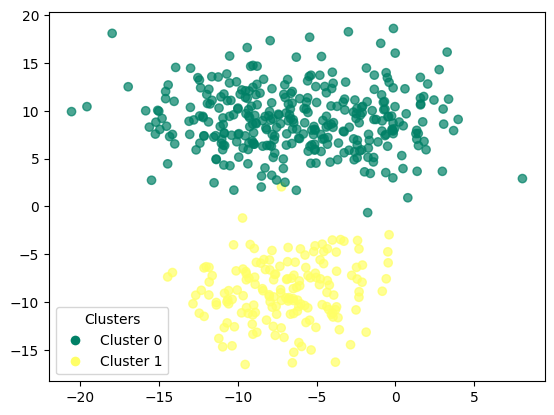

In [469]:
scatter = plt.scatter(df_tsne_dbscan.iloc[:, 0], df_tsne_dbscan.iloc[:, 1], 
                      c=df_tsne_dbscan['dbscan_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_dbscan['dbscan_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

### dbscan with umap

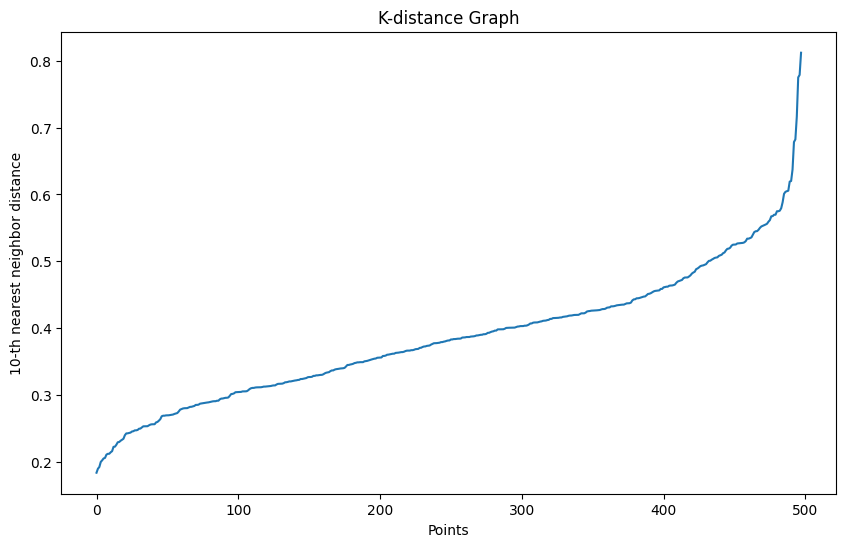

In [470]:
plot_k_distance_graph(X_umap,k=10)

In [471]:
dbscan_umap = DBSCAN(eps=0.6,min_samples=10)

In [472]:
dbscan_umap.fit(X_umap)

DBSCAN(eps=0.6, min_samples=10)

In [473]:
df_umap_dbscan = corr_dataset.copy()

In [474]:
df_umap_dbscan['dbscan_umap'] = dbscan_umap.labels_

In [475]:
y_true = df_umap_dbscan['target'].values  
y_kmeans = df_umap_dbscan['dbscan_umap'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_umap_dbscan['dbscan_umap'] = np.array([mapping[label] if label in mapping else -1 for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_umap_dbscan['dbscan_umap'] == y_true))

accuracy before: 0.6666666666666666
accuracy after: 0.6666666666666666


In [476]:
df_umap_dbscan

vab_1      vab_2     vab_3      vab_4      vab_5  target  dbscan_umap
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0            0
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0            0
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0            0
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0            0
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0            0
..         ...        ...       ...        ...        ...     ...          ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2            0
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2            0
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2            0
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2            0
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2            0

[498 rows x 7 columns]

In [477]:
print(df_umap_dbscan['dbscan_umap'].value_counts())

dbscan_umap
0    332
1    166
Name: count, dtype: int64


In [478]:
print(confusion_matrix(df_umap_dbscan['target'],df_umap_dbscan['dbscan_umap']))

[[166   0   0]
 [  0 166   0]
 [166   0   0]]


In [479]:
print(classification_report(df_umap_dbscan['target'],df_umap_dbscan['dbscan_umap']))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       166
           1       1.00      1.00      1.00       166
           2       0.00      0.00      0.00       166

    accuracy                           0.67       498
   macro avg       0.50      0.67      0.56       498
weighted avg       0.50      0.67      0.56       498



## GMM - Gaussian Mixture Models

In [480]:
gmm = GaussianMixture(n_components=3,init_params='k-means++',random_state=42)

In [481]:
gmm.fit(X_values)

GaussianMixture(init_params='k-means++', n_components=3, random_state=42)

In [482]:
df_gmm = corr_dataset.copy()

In [483]:
df_gmm['gmm'] = gmm.predict(X_values)

In [484]:
df_gmm

vab_1      vab_2     vab_3      vab_4      vab_5  target  gmm
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0    2
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0    2
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0    2
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0    1
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0    2
..         ...        ...       ...        ...        ...     ...  ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2    1
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2    1
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2    1
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2    1
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2    1

[498 rows x 7 columns]

In [485]:
y_true = df_gmm['target'].values  
y_kmeans = df_gmm['gmm'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_gmm['gmm'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_gmm['gmm'] == y_true))

accuracy before: 0.002008032128514056
accuracy after: 0.9397590361445783


In [486]:
df_gmm

vab_1      vab_2     vab_3      vab_4      vab_5  target  gmm
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0    0
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0    0
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0    0
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0    2
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0    0
..         ...        ...       ...        ...        ...     ...  ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2    2
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2    2
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2    2
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2    2
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2    2

[498 rows x 7 columns]

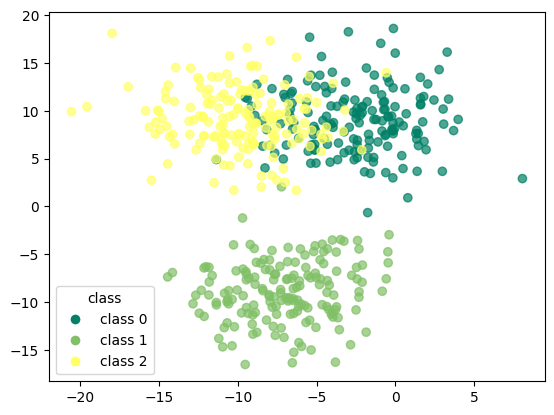

In [487]:
scatter = plt.scatter(df_gmm.iloc[:, 0], df_gmm.iloc[:, 1], 
                      c=df_gmm['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_gmm['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

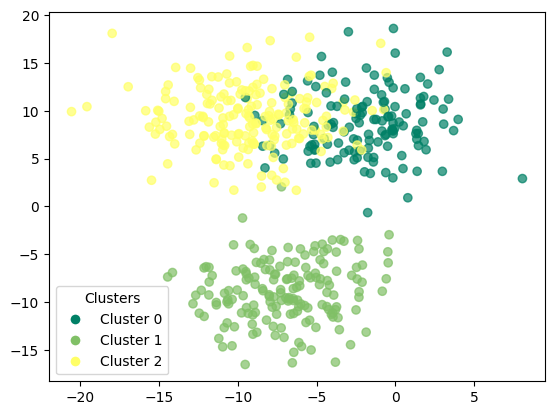

In [488]:
scatter = plt.scatter(df_gmm.iloc[:, 0], df_gmm.iloc[:, 1], 
                      c=df_gmm['gmm'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_gmm['gmm'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [489]:
print(confusion_matrix(df_gmm['target'],df_gmm['gmm']))

[[137   0  29]
 [  0 166   0]
 [  1   0 165]]


In [490]:
print(classification_report(df_gmm['target'],df_gmm['gmm']))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       166
           1       1.00      1.00      1.00       166
           2       0.85      0.99      0.92       166

    accuracy                           0.94       498
   macro avg       0.95      0.94      0.94       498
weighted avg       0.95      0.94      0.94       498



### GMM with pca

In [491]:
gmm_pca = GaussianMixture(n_components=3,init_params='k-means++',random_state=42)

In [492]:
gmm_pca.fit(scores_pca)

GaussianMixture(init_params='k-means++', n_components=3, random_state=42)

In [493]:
df_pca_gmm = corr_dataset.copy()

In [494]:
df_pca_gmm['gmm_pca'] = gmm_pca.predict(scores_pca)

In [495]:
df_pca_gmm

vab_1      vab_2     vab_3      vab_4      vab_5  target  gmm_pca
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0        2
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0        2
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0        2
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0        1
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0        2
..         ...        ...       ...        ...        ...     ...      ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2        1
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2        1
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2        1
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2        1
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2        1

[498 rows x 7 columns]

In [496]:
y_true = df_pca_gmm['target'].values  
y_kmeans = df_pca_gmm['gmm_pca'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_pca_gmm['gmm_pca'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_pca_gmm['gmm_pca'] == y_true))

accuracy before: 0.002008032128514056
accuracy after: 0.9357429718875502


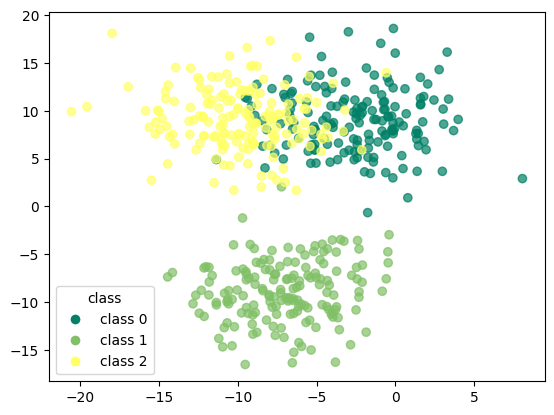

In [497]:
scatter = plt.scatter(df_pca_gmm.iloc[:, 0], df_pca_gmm.iloc[:, 1], 
                      c=df_pca_gmm['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_gmm['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

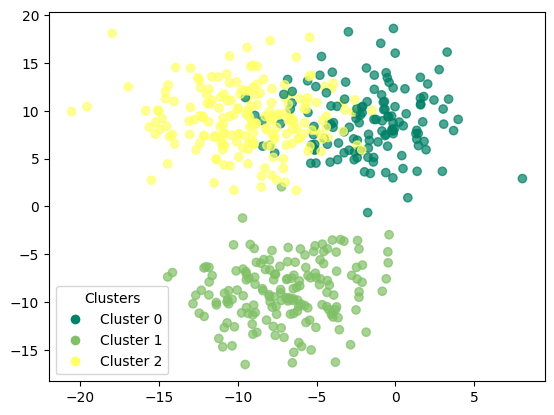

In [498]:
scatter = plt.scatter(df_pca_gmm.iloc[:, 0], df_pca_gmm.iloc[:, 1], 
                      c=df_pca_gmm['gmm_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_gmm['gmm_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [499]:
print(confusion_matrix(df_pca_gmm['target'],df_pca_gmm['gmm_pca']))

[[135   0  31]
 [  0 166   0]
 [  1   0 165]]


In [500]:
print(classification_report(df_pca_gmm['target'],df_pca_gmm['gmm_pca']))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89       166
           1       1.00      1.00      1.00       166
           2       0.84      0.99      0.91       166

    accuracy                           0.94       498
   macro avg       0.94      0.94      0.94       498
weighted avg       0.94      0.94      0.94       498



### GMM with t-SNE

In [501]:
gmm_tsne = GaussianMixture(n_components=3,init_params='k-means++',random_state=42)

In [502]:
gmm_tsne.fit(X_tsne)

GaussianMixture(init_params='k-means++', n_components=3, random_state=42)

In [503]:
df_tsne_gmm = corr_dataset.copy()

In [504]:
df_tsne_gmm['gmm_tsne'] = gmm_tsne.predict(X_tsne)

In [505]:
df_tsne_gmm

vab_1      vab_2     vab_3      vab_4      vab_5  target  gmm_tsne
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0         2
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0         2
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0         2
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0         1
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0         2
..         ...        ...       ...        ...        ...     ...       ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2         1
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2         1
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2         1
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2         1
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2         1

[498 rows x 7 columns]

In [506]:
y_true = df_tsne_gmm['target'].values  
y_kmeans = df_tsne_gmm['gmm_tsne'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_tsne_gmm['gmm_tsne'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_tsne_gmm['gmm_tsne'] == y_true))

accuracy before: 0.004016064257028112
accuracy after: 0.9759036144578314


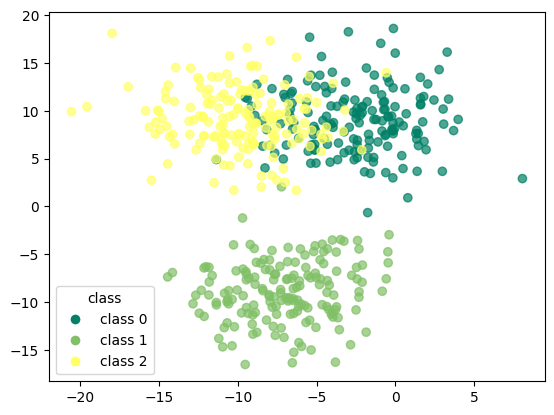

In [507]:
scatter = plt.scatter(df_tsne_gmm.iloc[:, 0], df_tsne_gmm.iloc[:, 1], 
                      c=df_tsne_gmm['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_tsne_gmm['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

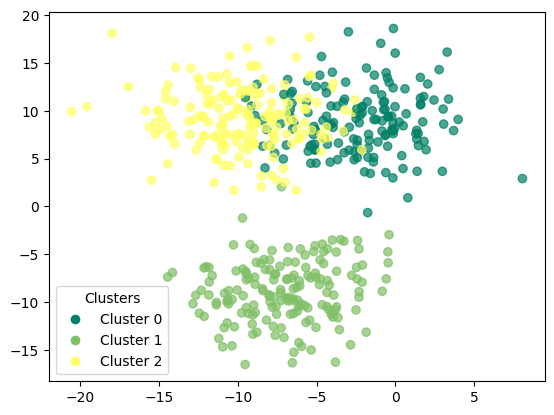

In [508]:
scatter = plt.scatter(df_tsne_gmm.iloc[:, 0], df_tsne_gmm.iloc[:, 1], 
                      c=df_tsne_gmm['gmm_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_gmm['gmm_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [509]:
print(confusion_matrix(df_tsne_gmm['target'],df_tsne_gmm['gmm_tsne']))

[[156   0  10]
 [  0 166   0]
 [  2   0 164]]


In [510]:
print(classification_report(df_tsne_gmm['target'],df_tsne_gmm['gmm_tsne']))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       166
           1       1.00      1.00      1.00       166
           2       0.94      0.99      0.96       166

    accuracy                           0.98       498
   macro avg       0.98      0.98      0.98       498
weighted avg       0.98      0.98      0.98       498



### GMM with umap

In [511]:
gmm_umap = GaussianMixture(n_components=3,init_params='k-means++',random_state=42)

In [512]:
gmm_umap.fit(X_umap)

GaussianMixture(init_params='k-means++', n_components=3, random_state=42)

In [513]:
df_umap_gmm = corr_dataset.copy()

In [514]:
df_umap_gmm['gmm_umap'] = gmm_umap.predict(X_umap)

In [515]:
df_umap_gmm

vab_1      vab_2     vab_3      vab_4      vab_5  target  gmm_umap
0    -2.939361   5.873120  3.670536   5.408232 -10.192434       0         2
1     1.354261   7.949398  2.886259   4.430629  -5.424494       0         2
2    -0.871902  11.659821  3.602247   2.559085 -10.689767       0         2
3    -5.438331  17.682938  8.916168  -0.225324 -10.825169       0         1
4    -2.103619   9.789868  4.839907   1.572048  -8.563410       0         2
..         ...        ...       ...        ...        ...     ...       ...
493 -14.939035   8.044888  9.980991  -6.578398  -5.221839       2         1
494  -9.337069   5.945577  4.507455  -5.357300 -10.264729       2         1
495 -10.952899   5.924296  8.206560  -6.229156  -1.637876       2         1
496  -3.302873   7.857255  2.963084 -10.894044  -9.993384       2         1
497 -14.575097  12.013696  7.495777  -4.168611 -14.307099       2         1

[498 rows x 7 columns]

In [516]:
y_true = df_umap_gmm['target'].values  
y_kmeans = df_umap_gmm['gmm_umap'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_umap_gmm['gmm_umap'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_umap_gmm['gmm_umap'] == y_true))

accuracy before: 0.002008032128514056
accuracy after: 0.9116465863453815


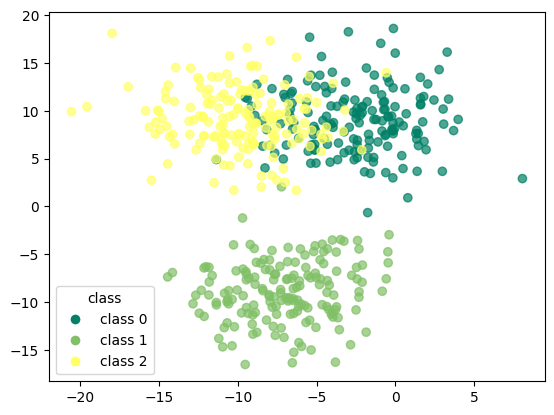

In [517]:
scatter = plt.scatter(df_umap_gmm.iloc[:, 0], df_umap_gmm.iloc[:, 1], 
                      c=df_umap_gmm['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_umap_gmm['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

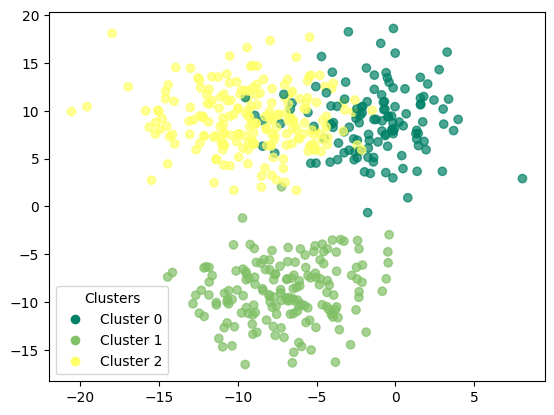

In [518]:
scatter = plt.scatter(df_umap_gmm.iloc[:, 0], df_umap_gmm.iloc[:, 1], 
                      c=df_umap_gmm['gmm_umap'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_umap_gmm['gmm_umap'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [519]:
print(confusion_matrix(df_umap_gmm['target'],df_umap_gmm['gmm_umap']))

[[123   0  43]
 [  0 166   0]
 [  1   0 165]]


In [520]:
print(classification_report(df_umap_gmm['target'],df_umap_gmm['gmm_umap']))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       166
           1       1.00      1.00      1.00       166
           2       0.79      0.99      0.88       166

    accuracy                           0.91       498
   macro avg       0.93      0.91      0.91       498
weighted avg       0.93      0.91      0.91       498



# overall results k-means

## basic

In [521]:
print(classification_report(df_kmeans['target'],df_kmeans['k_means']))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       166
           1       1.00      1.00      1.00       166
           2       0.97      0.96      0.97       166

    accuracy                           0.98       498
   macro avg       0.98      0.98      0.98       498
weighted avg       0.98      0.98      0.98       498



In [522]:
print(confusion_matrix(df_kmeans['target'],df_kmeans['k_means']))

[[161   0   5]
 [  0 166   0]
 [  6   0 160]]


## + pca

In [523]:
print(classification_report(df_pca_kmeans['target'],df_pca_kmeans['kmeans_pca']))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       166
           1       0.99      1.00      1.00       166
           2       0.94      0.98      0.96       166

    accuracy                           0.97       498
   macro avg       0.97      0.97      0.97       498
weighted avg       0.97      0.97      0.97       498



In [524]:
print(confusion_matrix(df_pca_kmeans['target'],df_pca_kmeans['kmeans_pca']))

[[155   1  10]
 [  0 166   0]
 [  3   0 163]]


## + t-SNE

In [525]:
print(classification_report(df_tsne_kmeans['target'],df_tsne_kmeans['kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       166
           1       1.00      1.00      1.00       166
           2       0.92      0.99      0.95       166

    accuracy                           0.97       498
   macro avg       0.97      0.97      0.97       498
weighted avg       0.97      0.97      0.97       498



In [526]:
print(confusion_matrix(df_tsne_kmeans['target'],df_tsne_kmeans['kmeans_tsne'])) 

[[151   0  15]
 [  0 166   0]
 [  2   0 164]]


## + UMAP

In [527]:
print(classification_report(df_umap_kmeans['target'],df_umap_kmeans['kmeans_umap'])) 

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       166
           1       1.00      1.00      1.00       166
           2       0.99      0.95      0.97       166

    accuracy                           0.98       498
   macro avg       0.98      0.98      0.98       498
weighted avg       0.98      0.98      0.98       498



In [528]:
print(confusion_matrix(df_umap_kmeans['target'],df_umap_kmeans['kmeans_umap'])) 

[[164   0   2]
 [  0 166   0]
 [  9   0 157]]


# overall results trimmed k-means

## basic

In [529]:
print(classification_report(df_trim_kmeans['target'],df_trim_kmeans['trim_kmeans']))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       154
           1       1.00      1.00      1.00       142
           2       0.94      0.98      0.96       152

    accuracy                           0.97       448
   macro avg       0.97      0.97      0.97       448
weighted avg       0.97      0.97      0.97       448



In [530]:
print(confusion_matrix(df_trim_kmeans['target'],df_trim_kmeans['trim_kmeans']))

[[144   0  10]
 [  0 142   0]
 [  3   0 149]]


## + pca

In [531]:
print(classification_report(df_pca_trim_kmeans['target'],df_pca_trim_kmeans['trim_kmeans_pca']))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       154
           1       0.99      1.00      0.99       142
           2       0.96      0.99      0.97       152

    accuracy                           0.98       448
   macro avg       0.98      0.98      0.98       448
weighted avg       0.98      0.98      0.98       448



In [532]:
print(confusion_matrix(df_pca_trim_kmeans['target'],df_pca_trim_kmeans['trim_kmeans_pca']))

[[145   2   7]
 [  0 142   0]
 [  2   0 150]]


## + t-SNE

In [533]:
print(classification_report(df_tsne_trim_kmeans['target'],df_tsne_trim_kmeans['trim_kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       154
           1       0.95      1.00      0.97       142
           2       0.95      0.96      0.95       152

    accuracy                           0.96       448
   macro avg       0.96      0.96      0.96       448
weighted avg       0.96      0.96      0.96       448



In [534]:
print(confusion_matrix(df_tsne_trim_kmeans['target'],df_tsne_trim_kmeans['trim_kmeans_tsne'])) 

[[143   3   8]
 [  0 142   0]
 [  1   5 146]]


## + UMAP

In [535]:
print(classification_report(df_umap_trim_kmeans['target'],df_umap_trim_kmeans['trim_kmeans_umap'])) 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       149
           1       1.00      1.00      1.00       166
           2       0.99      0.98      0.99       133

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



In [536]:
print(confusion_matrix(df_umap_trim_kmeans['target'],df_umap_trim_kmeans['trim_kmeans_umap'])) 

[[148   0   1]
 [  0 166   0]
 [  2   0 131]]


# overall results dbscan

## basic

In [537]:
print(classification_report(df_dbscan['target'],df_dbscan['dbscan']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       0.0
           0       0.00      0.00      0.00     166.0
           1       0.00      0.00      0.00     166.0
           2       0.00      0.00      0.00     166.0
           3       0.00      0.00      0.00       0.0

    accuracy                           0.00     498.0
   macro avg       0.00      0.00      0.00     498.0
weighted avg       0.00      0.00      0.00     498.0



In [538]:
print(confusion_matrix(df_dbscan['target'],df_dbscan['dbscan']))

[[  0   0   0   0   0]
 [ 33   0 133   0   0]
 [ 50   0   0   0 116]
 [ 29   0 137   0   0]
 [  0   0   0   0   0]]


## + pca

In [539]:
print(classification_report(df_pca_dbscan['target'],df_pca_dbscan['dbscan_pca']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       166
           1       1.00      0.89      0.94       166
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00         0

    accuracy                           0.30       498
   macro avg       0.20      0.18      0.19       498
weighted avg       0.33      0.30      0.31       498



In [540]:
print(confusion_matrix(df_pca_dbscan['target'],df_pca_dbscan['dbscan_pca']))

[[  0   0   0   0   0]
 [  7   0   0   0 159]
 [ 10   0 148   8   0]
 [ 16   0   0   0 150]
 [  0   0   0   0   0]]


## + t-SNE

In [541]:
print(classification_report(df_tsne_dbscan['target'],df_tsne_dbscan['dbscan_tsne']))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       166
           1       1.00      1.00      1.00       166
           2       0.00      0.00      0.00       166

    accuracy                           0.67       498
   macro avg       0.50      0.67      0.56       498
weighted avg       0.50      0.67      0.56       498



In [542]:
print(confusion_matrix(df_tsne_dbscan['target'],df_tsne_dbscan['dbscan_tsne']))

[[166   0   0]
 [  0 166   0]
 [166   0   0]]


## + UMAP

In [543]:
print(classification_report(df_umap_dbscan['target'],df_umap_dbscan['dbscan_umap']))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       166
           1       1.00      1.00      1.00       166
           2       0.00      0.00      0.00       166

    accuracy                           0.67       498
   macro avg       0.50      0.67      0.56       498
weighted avg       0.50      0.67      0.56       498



In [544]:
print(confusion_matrix(df_umap_dbscan['target'],df_umap_dbscan['dbscan_umap']))

[[166   0   0]
 [  0 166   0]
 [166   0   0]]


# overall results with GMM

## basic

In [545]:
print(classification_report(df_gmm['target'],df_gmm['gmm']))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       166
           1       1.00      1.00      1.00       166
           2       0.85      0.99      0.92       166

    accuracy                           0.94       498
   macro avg       0.95      0.94      0.94       498
weighted avg       0.95      0.94      0.94       498



In [546]:
print(confusion_matrix(df_gmm['target'],df_gmm['gmm']))

[[137   0  29]
 [  0 166   0]
 [  1   0 165]]


## + pca

In [547]:
print(classification_report(df_pca_gmm['target'],df_pca_gmm['gmm_pca']))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89       166
           1       1.00      1.00      1.00       166
           2       0.84      0.99      0.91       166

    accuracy                           0.94       498
   macro avg       0.94      0.94      0.94       498
weighted avg       0.94      0.94      0.94       498



In [548]:
print(confusion_matrix(df_pca_gmm['target'],df_pca_gmm['gmm_pca']))

[[135   0  31]
 [  0 166   0]
 [  1   0 165]]


## + t-SNE

In [549]:
print(classification_report(df_tsne_gmm['target'],df_tsne_gmm['gmm_tsne']))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       166
           1       1.00      1.00      1.00       166
           2       0.94      0.99      0.96       166

    accuracy                           0.98       498
   macro avg       0.98      0.98      0.98       498
weighted avg       0.98      0.98      0.98       498



In [550]:
print(confusion_matrix(df_tsne_gmm['target'],df_tsne_gmm['gmm_tsne']))

[[156   0  10]
 [  0 166   0]
 [  2   0 164]]


## + UMAP

In [551]:
print(classification_report(df_umap_gmm['target'],df_umap_gmm['gmm_umap']))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       166
           1       1.00      1.00      1.00       166
           2       0.79      0.99      0.88       166

    accuracy                           0.91       498
   macro avg       0.93      0.91      0.91       498
weighted avg       0.93      0.91      0.91       498



In [552]:
print(confusion_matrix(df_umap_gmm['target'],df_umap_gmm['gmm_umap']))

[[123   0  43]
 [  0 166   0]
 [  1   0 165]]
